In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Layer, MultiHeadAttention
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.layers import Masking, Input, Lambda
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
from numpy.fft import fft
from scipy.stats import skew, kurtosis 
import pandas as pd
import glob
import matplotlib.pyplot as plt
import os
import struct
import glob
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score

# Custom loss function
def custom_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    y_pred_clipped = tf.clip_by_value(y_pred, 1e-9, 1.0)  # Clip values to avoid log(0)
    entropy_reg = -tf.reduce_mean(y_pred_clipped * tf.math.log(y_pred_clipped))
    lambda_entropy = 0.01
    return mse + lambda_entropy * entropy_reg

def count_lines(filepath):
    with open(filepath, 'rb') as f:
        return sum(1 for _ in f)

class DataGenerator:        
    def __init__(self, filepath, batch_size, sequence_length, max_samples=None, for_training=True):
        self.filepath = filepath
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.max_samples = max_samples
        self.for_training = for_training
        self.samples = []
        self.binary_file = open(self.filepath, 'rb')  # Initialize the binary_file here
        self.reset()

    def reset(self):
        self.total_samples_processed = 0
        _, self.file_extension = os.path.splitext(self.filepath)
        print(f"File extension detected: {self.file_extension}")  # Add this line


    def __iter__(self):
        self.binary_file.seek(0)  # reset file pointer
        self.samples = []
        return self
    
    def close(self):
        if not self.binary_file.closed:
            self.binary_file.close()

    def process_data1(self, samples):
        real_parts = []
        imag_parts = []
        for sample in samples:
            try:
                cnum = complex(sample.replace('j', 'j'))
                real_parts.append(np.real(cnum))
                imag_parts.append(np.imag(cnum))
            except ValueError:
                continue

        real_parts = (real_parts - np.mean(real_parts)) / np.std(real_parts)
        imag_parts = (imag_parts - np.mean(imag_parts)) / np.std(imag_parts)

        X = [list(zip(real_parts[i:i+self.sequence_length], imag_parts[i:i+self.sequence_length])) for i in range(len(real_parts) - self.sequence_length)]
        return np.array(X)
    def process_data2(self, samples):
        # Convert samples list to a NumPy array and check the total number of samples
        samples_array = np.array(samples, dtype=np.complex64)
        total_samples = samples_array.size

        # Ensure that the total number of samples matches self.batch_size * self.sequence_length
        if total_samples != self.batch_size * self.sequence_length:
            # Handle this scenario: you might want to raise an error or handle it in some way
            raise ValueError("Total number of samples does not match batch_size * sequence_length")

        # Check for invalid values in samples_array before processing
        if np.isnan(samples_array).any() or np.isinf(samples_array).any():
            print(f"Invalid values found in samples_array: {samples_array}")
        # Reshape the samples array
        samples_array = samples_array.reshape(self.batch_size, self.sequence_length)
        print('samples_array.shape:', samples_array.shape)

        # Apply FFT to convert time-domain signals into frequency domain
        samples_fft = fft(samples_array)
        print('samples_fft.shape:', samples_fft.shape)

        # Extract real and imaginary parts
        real_parts = np.real(samples_fft)
        imag_parts = np.imag(samples_fft)

#         # Normalize the real and imaginary parts
#         real_parts = (real_parts - np.mean(real_parts, axis=1, keepdims=True)) / np.std(real_parts, axis=1, keepdims=True)
#         imag_parts = (imag_parts - np.mean(imag_parts, axis=1, keepdims=True)) / np.std(imag_parts, axis=1, keepdims=True)
        
        # Normalize the real and imaginary parts
        epsilon = 1e-10
        real_parts_mean = np.mean(real_parts, axis=1, keepdims=True)
        real_parts_std = np.std(real_parts, axis=1, keepdims=True)
        real_parts_std[real_parts_std == 0] = epsilon  # Avoid division by zero
        real_parts = (real_parts - real_parts_mean) / real_parts_std

        imag_parts_mean = np.mean(imag_parts, axis=1, keepdims=True)
        imag_parts_std = np.std(imag_parts, axis=1, keepdims=True)
        imag_parts_std[imag_parts_std == 0] = epsilon  # Avoid division by zero
        imag_parts = (imag_parts - imag_parts_mean) / imag_parts_std

        # Extract statistical features from the real and imaginary parts
        features = np.column_stack((
            np.mean(real_parts, axis=1),
            np.std(real_parts, axis=1),
            skew(real_parts, axis=1),
            kurtosis(real_parts, axis=1),
            np.mean(imag_parts, axis=1),
            np.std(imag_parts, axis=1),
            skew(imag_parts, axis=1),
            kurtosis(imag_parts, axis=1)
        ))

        # Reshape features to match the input shape of the model
        X = features.reshape(-1, self.sequence_length, features.shape[1])
        return X

    def __next__(self):
        chunksize = self.batch_size * self.sequence_length
        global totalMagnitude  # Access the global variable
        global totalnumberofsamples  # Access the global variable
        
        #if self.file_extension == '.dat':        
        samples = []
        while True:
            binary_data = self.binary_file.read(8)
            if not binary_data:
                break  # End of file
            decoded_data = struct.unpack('ff', binary_data)
            
            # Skip samples that are exactly zero (0 + 0j)
            if decoded_data[0] == 0 and decoded_data[1] == 0:
                continue

            # Convert the binary data to a complex number string
            decoded_line = f"{decoded_data[0]}+{decoded_data[1]}j\n" if decoded_data[1] >= 0 else f"{decoded_data[0]}{decoded_data[1]}j\n"
            samples.append(decoded_line)

            # Check if we have enough samples for a batch
            if len(samples) == chunksize:
                X_chunk = self.process_data1(samples)
                #X_chunk = self.process_data2(samples)
                if self.for_training:
                    return X_chunk, X_chunk
                else:
                    return X_chunk
                # Clear samples for the next batch (optional, depends on your logic)
                samples = []
#------------------------------------------------------------------------------------------------------
# Minimum Entropy Coupling (MEC) Functions
# def mec_kocaoglu_np(p, q):
#     """
#     Compute the joint distribution matrix with minimal entropy between two given distributions.
#     """
#     p = tf.cast(p, tf.float64) / tf.reduce_sum(p)
#     q = tf.cast(q, tf.float64) / tf.reduce_sum(q)
#     J = tf.zeros((tf.size(q), tf.size(p)), dtype=tf.float64)
#     M = tf.stack([p, q], axis=0)
#     r = tf.reduce_min(tf.reduce_max(M, axis=1))
#     #print('Input shapes to mec_kocaoglu_np:', p.shape, q.shape)
#     def body(r, M, J):
#         a_i = tf.argmax(M, axis=1)
#         r_updated = tf.reduce_min(tf.reduce_max(M, axis=1))
#         update_values = tf.stack([r, r])
#         # ensure tensors have same datatype
#         a_i = tf.cast(a_i, dtype=tf.int32)
#         indices_range = tf.range(tf.size(a_i), dtype=tf.int32)
#         #prepare indices for scatter update
#         indices = tf.stack([indices_range, a_i], axis=1)
#         #now update
#         M_updates = tf.scatter_nd(indices, -update_values, tf.shape(M))
#         M = M + M_updates
#         J_updates = tf.scatter_nd(indices, [r, r], tf.shape(J))
#         J = J + J_updates
#         return r_updated, M, J

#     def condition(r, M, J):
#         return r > 0
#     r, M, J = tf.while_loop(condition, body, loop_vars=[r, M, J])
#     return J

# def apply_mec_to_data(data, num_bins=25, latent_dim=25):
#     print('data.shape in apply mec:', data.shape)
#     """
#     Apply the MEC transformation to each sample in the data using tf.map_fn.
#     """
#     def process_sample(sample):
#         min_val = tf.reduce_min(sample)
#         max_val = tf.reduce_max(sample)
#         sample_distribution = tf.histogram_fixed_width(sample, [min_val, max_val], nbins=num_bins)
#         sample_distribution = tf.cast(sample_distribution, tf.float64)
#         sum_distribution = tf.cast(tf.reduce_sum(sample_distribution), tf.float64)
#         sample_distribution /= sum_distribution

#         mec_transformed = mec_kocaoglu_np(sample_distribution, sample_distribution)

#         # Flatten the 2D to 1D
#         if len(mec_transformed.shape) > 1:
#             transformed_sample = tf.reshape(mec_transformed, [-1])

#         # slice/pad to match the latent_dim
#         if transformed_sample.shape[0] > latent_dim:
#             transformed_sample = transformed_sample[:latent_dim]
#         elif transformed_sample.shape[0] < latent_dim:
#             padding = tf.zeros(latent_dim - transformed_sample.shape[0], dtype=tf.float64)
#             transformed_sample = tf.concat([transformed_sample, padding], axis=0)

#         return tf.reshape(transformed_sample, (latent_dim,))
#     # apply function to each sample in the batch
#     transformed_batch = tf.map_fn(process_sample, data, dtype=tf.float64, parallel_iterations=10)

#     return transformed_batch
def mec_kocaoglu_np(p, q):
    """
    Compute the joint distribution matrix with minimal entropy between two given distributions.
    """
    p = tf.cast(p, tf.float64) / tf.reduce_sum(p)
    q = tf.cast(q, tf.float64) / tf.reduce_sum(q)
    J = tf.zeros((tf.size(q), tf.size(p)), dtype=tf.float64)
    M = tf.stack([p, q], axis=0)
    r = tf.reduce_min(tf.reduce_max(M, axis=1))
    #print('Input shapes to mec_kocaoglu_np:', p.shape, q.shape)
    def body(r, M, J):
        a_i = tf.argmax(M, axis=1)
        r_updated = tf.reduce_min(tf.reduce_max(M, axis=1))
        update_values = tf.stack([r, r])
        # ensure tensors have same datatype
        a_i = tf.cast(a_i, dtype=tf.int32)
        indices_range = tf.range(tf.size(a_i), dtype=tf.int32)
        #prepare indices for scatter update
        indices = tf.stack([indices_range, a_i], axis=1)
        #now update
        M_updates = tf.scatter_nd(indices, -update_values, tf.shape(M))
        M = M + M_updates
        J_updates = tf.scatter_nd(indices, [r, r], tf.shape(J))
        J = J + J_updates
        return r_updated, M, J

    def condition(r, M, J):
        return r > 0
    r, M, J = tf.while_loop(condition, body, loop_vars=[r, M, J])
    return J

def apply_mec_to_data(z_mean, z, num_bins=25, latent_dim=25):
    """
    Apply the MEC transformation to each pair of samples in z_mean and z using tf.map_fn.
    """
    def process_pair(pair):
        #z_mean_sample, z_sample = pair
        z_mean_sample = pair[0]
        z_sample = pair[1]
        
        # Dynamically calculate the range and number of bins
        min_val = tf.reduce_min([z_mean_sample, z_sample])
        max_val = tf.reduce_max([z_mean_sample, z_sample])
        num_bins_dynamic = tf.cast(tf.sqrt(tf.size(z_mean_sample, out_type=tf.float32)), tf.int32)

        # Calculate histogram for z_mean_sample
        min_val_z_mean = tf.reduce_min(z_mean_sample)
        max_val_z_mean = tf.reduce_max(z_mean_sample)
        z_mean_distribution = tf.histogram_fixed_width(z_mean_sample, [min_val_z_mean, max_val_z_mean], nbins=num_bins)
        #z_mean_distribution = tf.histogram_fixed_width(z_mean_sample, [min_val, max_val], nbins=num_bins_dynamic)
        z_mean_distribution = tf.cast(z_mean_distribution, tf.float64)
        z_mean_distribution = tf.cast(z_mean_distribution, tf.float64) / tf.reduce_sum(z_mean_distribution)

        # Calculate histogram for z_sample
        min_val_z = tf.reduce_min(z_sample)
        max_val_z = tf.reduce_max(z_sample)
        z_distribution = tf.histogram_fixed_width(z_sample, [min_val_z, max_val_z], nbins=num_bins)
        #z_distribution = tf.histogram_fixed_width(z_sample, [min_val, max_val], nbins=num_bins_dynamic)
        z_distribution = tf.cast(z_distribution, tf.float64)
        z_distribution = tf.cast(z_sample, tf.float64)
        z_distribution = tf.cast(z_distribution, tf.float64) / tf.reduce_sum(z_distribution)

        # Apply MEC using the distributions
        mec_transformed = mec_kocaoglu_np(z_mean_distribution, z_distribution)

        # Flatten the 2D to 1D
        if len(mec_transformed.shape) > 1:
            transformed_pair = tf.reshape(mec_transformed, [-1])

        # Slice/pad to match the latent_dim
        if transformed_pair.shape[0] > latent_dim:
            transformed_pair = transformed_pair[:latent_dim]
        elif transformed_pair.shape[0] < latent_dim:
            padding = tf.zeros(latent_dim - transformed_pair.shape[0], dtype=tf.float64)
            transformed_pair = tf.concat([transformed_pair, padding], axis=0)

        return tf.reshape(transformed_pair, (latent_dim,))

    # Stack z_mean and z to create pairs for map_fn
    pairs = tf.stack([z_mean, z], axis=1)
    # Apply function to each pair in the batch
    transformed_batch = tf.map_fn(process_pair, pairs, dtype=tf.float64, parallel_iterations=10)
    return transformed_batch

def process_latent_variables(z_mean, z):
    z_transformed = apply_mec_to_data(z_mean, z)
    #print('Output of MEC transformation shape:', z_transformed.shape)
    return z_transformed

# def process_latent_variables(z):
#     z_transformed = apply_mec_to_data(z)
#     #print('Output of MEC transformation shape:', z_transformed.shape)
#     return z_transformed
#self Attention LSTM Autoencoder Model
class SelfAttentionLayer(Layer):
    def __init__(self, num_heads, key_dim):
        super(SelfAttentionLayer, self).__init__()
        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, inputs):
        return self.multi_head_attention(inputs, inputs, inputs)
# Variational Autoencoder (VAE) Class
class VAE:
    def __init__(self, sequence_length, feature_dim, original_dim, intermediate_dim, latent_dim,
                 epsilon_std=0.1, dropout_rate=0.2):
        self.sequence_length = sequence_length
        self.feature_dim = feature_dim
        self.original_dim = original_dim
        self.intermediate_dim = intermediate_dim
        self.latent_dim = latent_dim
        self.epsilon_std = epsilon_std
        self.dropout_rate = dropout_rate
        self.encoder = None
        self.decoder = None
        self.vae = None
        self._build()
        #self._build2()

    def _sampling3(self, args):
        z_mean, _ = args  # Ignore z_log_var for simplicity
        #tf.print('z_mean:', z_mean)
        z_mean_transformed = process_latent_variables(z_mean)
        #tf.print('z_mean_transformed:', z_mean_transformed)
        epsilon_std = 0.1  # Use a fixed small std deviation to reduce variability
        #epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=epsilon_std)
        epsilon = K.random_normal(shape=K.shape(z_mean_transformed), mean=0., stddev=epsilon_std)
        #epsilon = process_latent_variables(epsilon)
        #tf.print('epsilon_value:', epsilon)
        epsilon = tf.cast(epsilon, 'float64')  # Cast epsilon to float64
        
        #a = z_mean_transformed + epsilon
        #tf.print('a:', a)
        #return a
        return z_mean_transformed
        #return z_mean + epsilon
    def _sampling(self, args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=self.epsilon_std)
        output = z_mean + K.exp(0.5 * z_log_var) * epsilon
        return output
    def _sampling33(self, args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=self.epsilon_std)
        # Standard reparameterization trick
        z = z_mean + K.exp(0.5 * z_log_var) * epsilon
        # Consider z_mean as x and z as y for MEC application
        z_mec = apply_mec_to_data(z_mean, z)
        # Convert z_mec to float32 to match z_mean and z_log_var
        z_mec = tf.cast(z_mec, dtype=tf.float32)
        z_mec = z_mean + K.exp(0.5 * z_log_var) * z_mec
        return z_mec
        
    def _build(self):
        # Encoder
        #model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 8), 
                       #return_sequences=True)
        inputs = Input(shape=(self.sequence_length, self.feature_dim), name='encoder_input')
        #x = Bidirectional(LSTM(self.intermediate_dim, activation='tanh', return_sequences=True))(inputs)
        x = LSTM(self.original_dim, activation='tanh', return_sequences=True)(inputs)
        #x = Dropout(self.dropout_rate)(x)
        self_attention = SelfAttentionLayer(num_heads=2, key_dim=self.original_dim)  # Adjust num_heads and key_dim as needed
        x = self_attention(x)
        x = LSTM(self.intermediate_dim, activation='tanh', return_sequences=False)(x)
        #x = Dropout(self.dropout_rate)(x)

        z_mean = Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = Dense(self.latent_dim, name='z_log_var')(x)
        
        z = Lambda(self._sampling33, output_shape=(self.latent_dim,))([z_mean, z_log_var])
        # Initiate Encoder
        self.encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')  
        # Decoder
        latent_inputs = Input(shape=(self.latent_dim,), name='z_sampling')
        x = RepeatVector(self.sequence_length)(latent_inputs)
        x = LSTM(self.intermediate_dim, activation='tanh', return_sequences=True)(x)
        #x = Dropout(self.dropout_rate)(x)
        x = LSTM(self.original_dim, activation='tanh', return_sequences=True)(x)
        #x = Dropout(self.dropout_rate)(x)
        final_activation = 'sigmoid' #'linear' if data is not normalized
        #outputs = TimeDistributed(Dense(self.original_dim, activation=final_activation))(x)
        outputs = TimeDistributed(Dense(self.feature_dim))(x)
        # Instantiate the decoder model
        self.decoder = Model(latent_inputs, outputs, name='decoder')
        # VAE model
        outputs = self.decoder(self.encoder(inputs)[2])
        self.vae = Model(inputs, outputs, name='vae_mlp')

    def vae_loss(self, x, x_decoded_mean, z_mean, z_log_var):
        mse = tf.reduce_mean(tf.square(x - x_decoded_mean), axis=(1, 2))
        xent_loss = mse
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    def simplified_vae_loss(self, x, x_decoded_mean, z_mean):
        mse = tf.reduce_mean(tf.square(x - x_decoded_mean), axis=(1, 2))
        mean_loss = tf.reduce_mean(tf.square(z_mean))
        total_loss = mse + mean_loss
        return K.mean(total_loss)
    
    def compile(self, learning_rate=0.001, optimizer='adam'):
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)

        def vae_loss_wrapper(x, x_decoded_mean):
            z_mean, z_log_var, _ = self.encoder(x)
            return self.vae_loss(x, x_decoded_mean, z_mean, z_log_var)

        self.vae.compile(optimizer=optimizer, loss=vae_loss_wrapper)

    def compile2(self, learning_rate=0.0005, optimizer='adam'):
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)

        # Define a wrapper function for the custom loss
        def custom_loss_wrapper(x, x_decoded_mean):
            z_mean, z_log_var, _ = self.encoder(x)
            return self.custom_loss(x, x_decoded_mean, z_mean, z_log_var)

        self.vae.compile(optimizer=optimizer, loss=custom_loss_wrapper)
    def compile_custom(self, learning_rate=0.001, optimizer='adam'):
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)
        def custom_loss_wrapper(x, x_decoded_mean):
            z_mean, _, _ = self.encoder(x)
            return self.simplified_vae_loss(x, x_decoded_mean, z_mean)

        self.vae.compile(optimizer=optimizer, loss=custom_loss_wrapper)
    def compile_simple_autoencoder(self, learning_rate=0.005, optimizer='adam'):
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)
        
        # Simple reconstruction loss
        self.vae.compile(optimizer=optimizer, loss='mse')

# Instantiate and Compile the VAE
sequence_length = 10
feature_dim = 2
original_dim = 50
intermediate_dim = 50
latent_dim = 25

vae_model = VAE(sequence_length, feature_dim, original_dim, intermediate_dim, latent_dim)
#vae_model.vae.compile(optimizer='adam', loss=vae_model.vae_loss)
#vae_model.compile2(learning_rate=0.005)
vae_model.compile_simple_autoencoder(learning_rate=0.005)
#vae_model.compile_custom(learning_rate=0.005)

# Model Training
batch_size = 40
max_train_samples = 1000000
train_steps = max_train_samples // (batch_size * sequence_length)
max_samples = 1000000  # Maximum samples to read (or None to read all)
max_test_samples = 1000000

pure_file_pattern = '/home/mreza/5G accelerator/ID_MEC/data generator/pure_data/pure_iq_samples_*.csv'
mixed_file_pattern = '/home/mreza/5G accelerator/ID_MEC/data generator/mixed_data/mixed_iq_samples_*.csv'
pure_file_new = '/home/mreza/5G accelerator/ID_MEC/data generator/New Data-Collection/rx_IQ_pure'
mixed_file_new = '/home/mreza/5G accelerator/ID_MEC/data generator/New Data-Collection/rx_IQ_MIX'
pure_file_old = '/home/mreza/5G accelerator/IQ_samples/data collected/5G_DL_IQ_no_jamming_0924.dat'
mixed_file_old = '/home/mreza/5G accelerator/IQ_samples/data collected/5G_DL_IQ_with_periodic_jamming_0928_02.dat'
# Example file patterns
#pure_file_pattern = 'C:\\Users\\Mohammadreza\\Desktop\\My Class\\Proj-DC\\My Works\\My Papers\\intrusion\\data generator\\pure_data\\pure_iq_samples_*.csv'
#mixed_file_pattern = 'C:\\Users\\Mohammadreza\\Desktop\\My Class\\Proj-DC\\My Works\\My Papers\\intrusion\\data generator\\mixed_data\\mixed_iq_samples_*.csv'

# Data Generator Instances
# train_gen_instance = CSVDataGenerator(pure_file_pattern, batch_size, sequence_length, 
#                                       max_train_samples, for_training=True)
# combined_gen_instance = CSVDataGenerator(mixed_file_pattern, batch_size, sequence_length, 
#                                          max_test_samples, for_training=False)
train_gen_instance = DataGenerator(pure_file_new,batch_size=batch_size, sequence_length=sequence_length, 
                                   max_samples=max_train_samples, for_training=True)
combined_gen_instance = DataGenerator(mixed_file_new,batch_size=batch_size, sequence_length=sequence_length, 
                                      for_training=False)

collected_z_means = []
collected_z_log_var= []
collected_z = [] 
collected_z_sampled_vae = []
losses = []
num_epochs = 2
steps_per_epoch = train_steps  # Assuming one epoch processes all the data
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_gen_instance.reset()  # Reset the generator at the beginning of each epoch
    for step in range(steps_per_epoch):
        try:
            X_chunk, Y_chunk = next(train_gen_instance)
        except StopIteration:
            train_gen_instance.reset()  # Reset the generator when it runs out of data
            X_chunk, Y_chunk = next(train_gen_instance)
        if epoch < 1:
            if step < 1:
                print('epoch for d-collection:', epoch)
                print('step for d-collection:', step)
                z_mean, z_log_var, z = vae_model.encoder(X_chunk)
                collected_z_means.append(z_mean.numpy())
                collected_z_log_var.append(z_log_var.numpy())
                collected_z.append(z.numpy()) 

        #loss = model.train_on_batch(X_chunk, Y_chunk)
        loss = vae_model.vae.train_on_batch(X_chunk, Y_chunk)
        losses.append(loss)
        #print(f"Step {step + 1}/{steps_per_epoch}", end='\r')
        if step % 100 == 0:
            print(f"Step {step + 1}/{train_steps}, Loss: {loss}")
    print()

num_predictions = 100  # or any other large number
print(f"Number of predictions to be performed: {num_predictions}")


reconstruction_errors = []
all_X_chunk_test = []
all_X_chunk_pred = []
all_intrusion_flags = []
try:
    for _ in range(num_predictions):
        print('prediction number:', _)
        X_chunk_test = next(combined_gen_instance)
        #X_chunk_pred = model.predict(X_chunk_test)
        X_chunk_pred = vae_model.vae.predict(X_chunk_test)
        chunk_errors = np.mean(np.square(X_chunk_test - X_chunk_pred), axis=1)
        reconstruction_errors.extend(chunk_errors)        
        all_X_chunk_test.append(X_chunk_test)
        all_X_chunk_pred.append(X_chunk_pred)
except StopIteration:
    print("All samples processed.")


reconstruction_error = np.array(reconstruction_errors)
print('reconstruction_error.shape:', reconstruction_error.shape)
print('Number of NaNs in reconstruction_error:', np.isnan(reconstruction_error).sum())
max_error_per_sequence = reconstruction_error.max(axis=1) # Max error for each sequence
print('max_error_per_sequence:', max_error_per_sequence)

print('max_error_per_sequence.shape:', max_error_per_sequence.shape)

threshold1 = np.percentile(max_error_per_sequence, 98)
print('threshold1:', threshold1)
threshold2 = np.percentile(reconstruction_error, 95)
print('threshold percentile:', threshold2)

is_intrusion_detected = max_error_per_sequence > threshold1  # Boolean array for sequences
print('len(is_intrusion_detected):', len(is_intrusion_detected))
print('is_intrusion_detected.shape:', is_intrusion_detected.shape)

#is_intrusion_detected2 = error_per_sequence > threshold1

num_total_sequences = len(max_error_per_sequence)
num_total_sequences2 = num_predictions * batch_size - num_predictions
print('num_total_sequences:', num_total_sequences)
print('num_total_sequences2:', num_total_sequences2)

#---------------------------------------finish 111-----------------------------------
flat_error_per_sequence = max_error_per_sequence.flatten()
#flat_error_per_sequence2 = error_per_sequence.flatten()
# Determine if intrusion detected for each sequence
for error in flat_error_per_sequence:
    all_intrusion_flags.append(error > threshold1)    
all_X_chunk_test = np.concatenate(all_X_chunk_test, axis=0)
all_X_chunk_pred = np.concatenate(all_X_chunk_pred, axis=0)

#save_path = 'C:\\Users\\Mohammadreza\\Desktop\\My Class\\Proj-DC\\My Works\\My Papers\\intrusion\\data generator\\intrusion_detected'
#plot_with_intrusions8(all_X_chunk_test, all_X_chunk_pred, all_intrusion_flags, sequence_length, save_path)

jamming_detected = reconstruction_error > threshold1
train_gen_instance.close()
combined_gen_instance.close()
#Table
flattened_jamming_detected = jamming_detected.flatten()
real_part_detected = jamming_detected[:, 0]
imag_part_detected = jamming_detected[:, 1]

real_true_count = np.sum(real_part_detected)
real_false_count = len(real_part_detected) - real_true_count

imag_true_count = np.sum(imag_part_detected)
imag_false_count = len(imag_part_detected) - imag_true_count
# Overall
overall_true_count = np.sum(flattened_jamming_detected)
overall_false_count = len(flattened_jamming_detected) - overall_true_count
# Table-DataFrame
df_predicted = pd.DataFrame({
    'Part': ['Real', 'Imaginary', 'Overall'],
    'True Count': [real_true_count, imag_true_count, overall_true_count],
    'False Count': [real_false_count, imag_false_count, overall_false_count]
})
print(df_predicted)
num_jamming_detected = np.sum(jamming_detected)
print(f"Number of jamming sequences detected: {num_jamming_detected} out of {len(flattened_jamming_detected)} sequences")




2024-05-15 15:05:41.777685: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-15 15:05:41.785196: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-15 15:05:41.830743: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-15 15:05:41.831176: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 15:05:42.357423: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Instructions for updating:
Use fn_output_signature instead
File extension detected: 
File extension detected: 
Epoch 1/2
File extension detected: 
epoch for d-collection: 0
step for d-collection: 0
Step 1/2500, Loss: 0.9969308972358704
Step 101/2500, Loss: 0.04596147686243057
Step 201/2500, Loss: 0.8761326670646667
Step 301/2500, Loss: 0.07502000033855438
Step 401/2500, Loss: 0.7850757241249084
Step 501/2500, Loss: 0.8046839237213135
Step 601/2500, Loss: 0.13588093221187592
Step 701/2500, Loss: 0.8002850413322449
Step 801/2500, Loss: 0.8364203572273254
Step 901/2500, Loss: 0.028458526358008385
Step 1001/2500, Loss: 0.7659729719161987
Step 1101/2500, Loss: 0.8081018924713135
Step 1201/2500, Loss: 0.017709456384181976
Step 1301/2500, Loss: 0.7237030267715454
Step 1401/2500, Loss: 0.07226192206144333
Step 1501/2500, Loss: 0.7334604263305664
Step 1601/2500, Loss: 0.7688918113708496
Step 1701/2500, Loss: 0.7350888252258301
Step 1801/2500, Loss: 0.7541906833648682
Step 1901/2500, Loss: 0.749

13/13 [==============================] - 0s 9ms/step
prediction number: 74
13/13 [==============================] - 0s 9ms/step
prediction number: 75
13/13 [==============================] - 0s 9ms/step
prediction number: 76
13/13 [==============================] - 0s 9ms/step
prediction number: 77
13/13 [==============================] - 0s 9ms/step
prediction number: 78
13/13 [==============================] - 0s 9ms/step
prediction number: 79
13/13 [==============================] - 0s 9ms/step
prediction number: 80
13/13 [==============================] - 0s 9ms/step
prediction number: 81
13/13 [==============================] - 0s 9ms/step
prediction number: 82
13/13 [==============================] - 0s 9ms/step
prediction number: 83
13/13 [==============================] - 0s 9ms/step
prediction number: 84
13/13 [==============================] - 0s 9ms/step
prediction number: 85
13/13 [==============================] - 0s 9ms/step
prediction number: 86
13/13 [==================

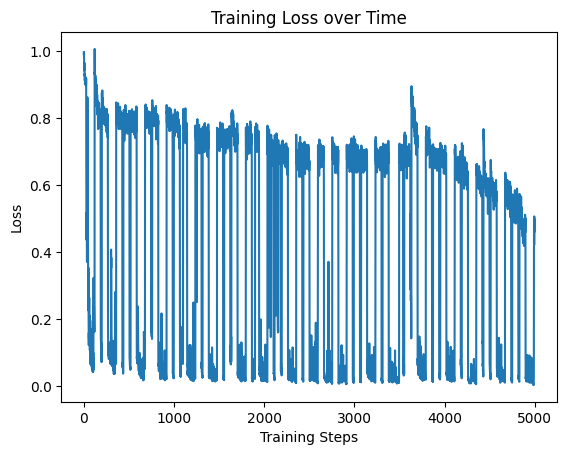

In [2]:
# Plotting the loss
plt.plot(losses)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.show()

In [3]:
def plot_with_intrusions8(all_X_chunk_test, all_X_chunk_pred, all_intrusion_flags, sequence_length, save_path):
    for idx in range(0, len(all_X_chunk_test), sequence_length):
        sequence_idx = idx // sequence_length
        if all_intrusion_flags[sequence_idx]:
            plt.figure(figsize=(14, 6))
            time_steps = np.arange(idx * sequence_length, (idx + 1) * sequence_length)

            real_part_test = all_X_chunk_test[idx, :, 0].reshape(-1)
            imag_part_test = all_X_chunk_test[idx, :, 1].reshape(-1)
            real_part_pred = all_X_chunk_pred[idx, :, 0].reshape(-1)
            imag_part_pred = all_X_chunk_pred[idx, :, 1].reshape(-1)

            plt.plot(time_steps, real_part_test, 'b-', label='Original Real', linewidth=2)
            plt.plot(time_steps, real_part_pred, 'r--', label='Reconstructed Real', linewidth=2)
            plt.plot(time_steps, imag_part_test, 'g-', label='Original Imag', linewidth=2)
            plt.plot(time_steps, imag_part_pred, 'y--', label='Reconstructed Imag', linewidth=2)
            
            # Define where the fill should be applied (assuming the entire range for this example)
            where_fill = np.full_like(time_steps, True, dtype=bool)  # Fill the entire range
            plt.fill_between(time_steps, -3, 3, where=where_fill, color=(1, 0.5, 0.5), alpha=0.3, label='Intrusion Detected')

            #plt.fill_between(time_steps, -3, 3, where=True, color=(1, 0.5, 0.5), alpha=0.3, label='Intrusion Detected')
            
            # Enhancing font size and making bold
            plt.title(f'Original vs Reconstructed with Intrusion (Sequence {sequence_idx})', fontsize=18, fontweight='bold')
            plt.xlabel('Sample Index', fontsize=16, fontweight='bold')
            plt.ylabel('IQ Sample', fontsize=16, fontweight='bold')
            plt.legend(loc='lower right', fontsize=15)

            # Enhancing xtick and ytick labels
            for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
                label.set_fontsize(13)
                label.set_fontweight('bold')

            plt.tight_layout()

            filename = os.path.join(save_path, f'intrusion_sequence_{sequence_idx}.png')
            plt.savefig(filename)
            plt.close()

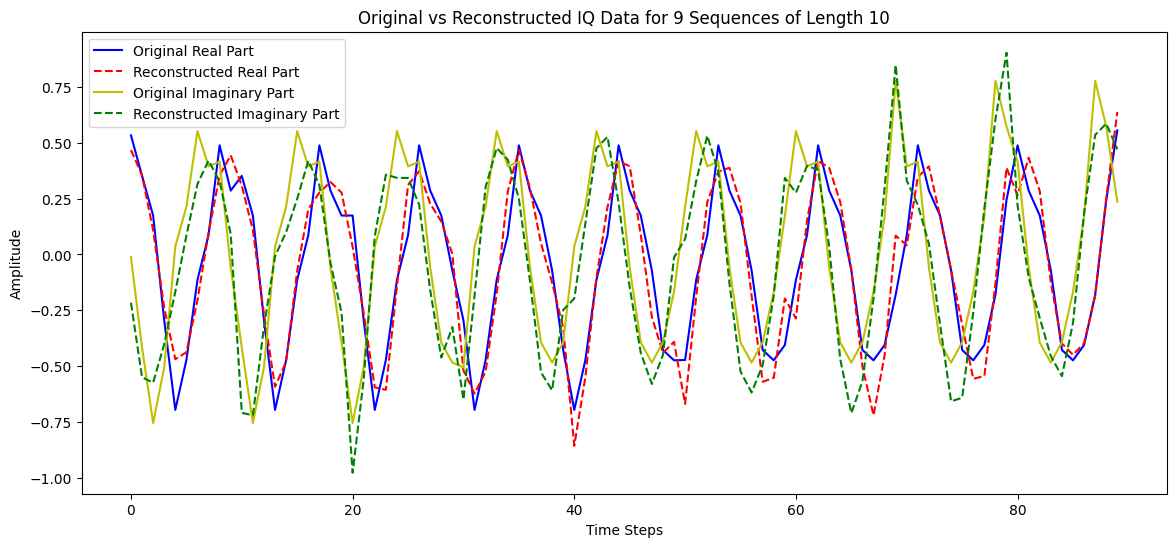

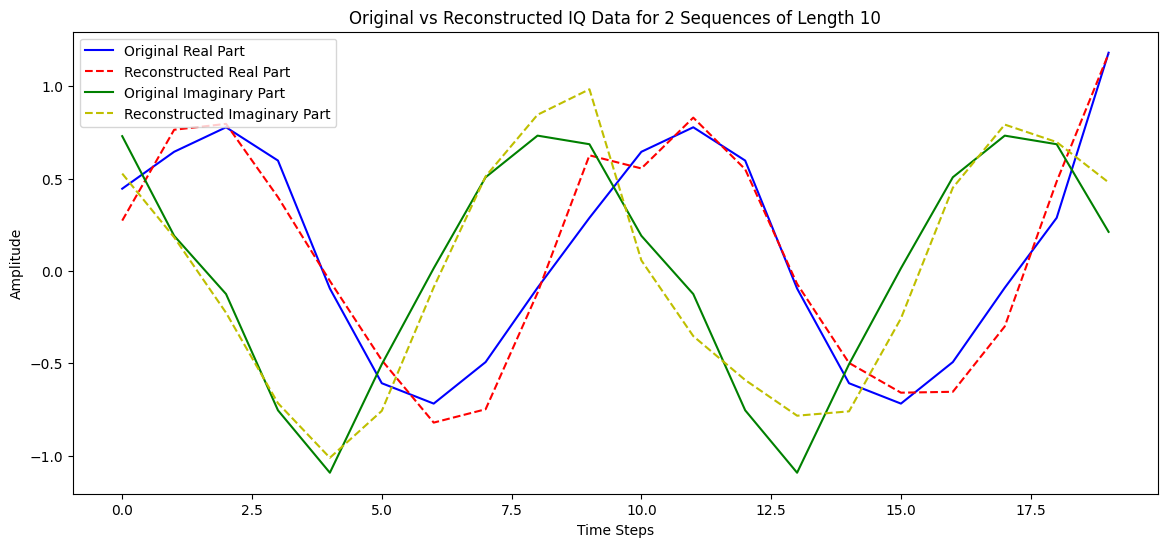

In [4]:
# # Define the number of sequences to plot together
n = 9  # Change this to desired number of sequences
sample_length = sequence_length * n

# Select a random starting sequence for plotting
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)

# Extract and concatenate the original and reconstructed samples
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

# Plot concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
# plt.plot(original_sample[:, 1], 'orange', label='Original Real STD')
# plt.plot(reconstructed_sample[:, 1], 'orange', label='Reconstructed Real STD', linestyle='--')

plt.plot(original_sample[:, 1], 'y-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'g--', label='Reconstructed Imaginary Part')
# plt.plot(original_sample[:, 5], 'pink', label='Original Imaginary STD')
# plt.plot(reconstructed_sample[:, 5], 'pink', label='Reconstructed Imaginary STD', linestyle='--')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('9-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

# Repeat for n = 9
n = 2  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

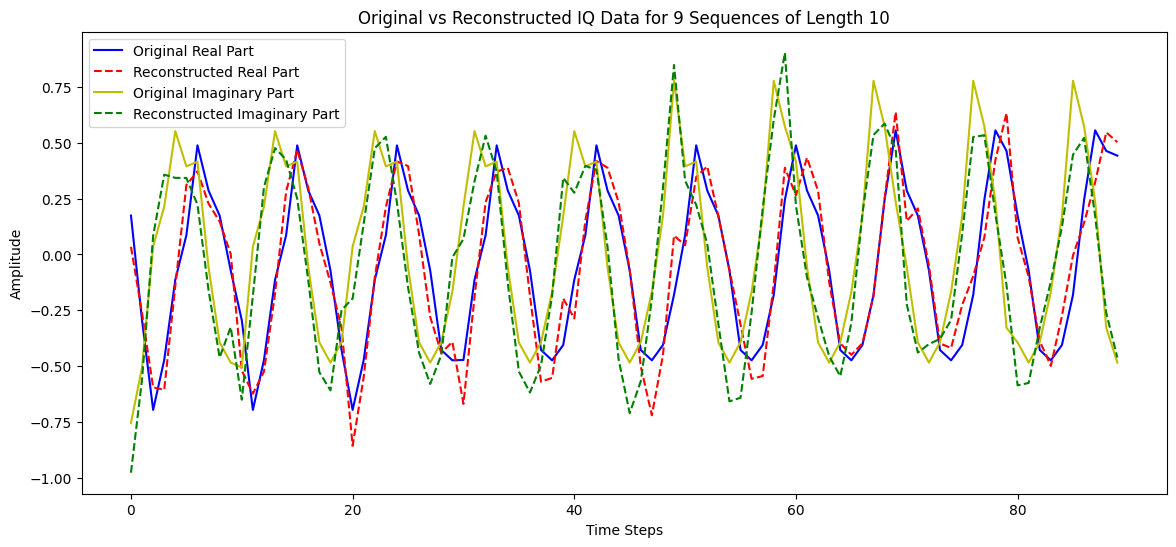

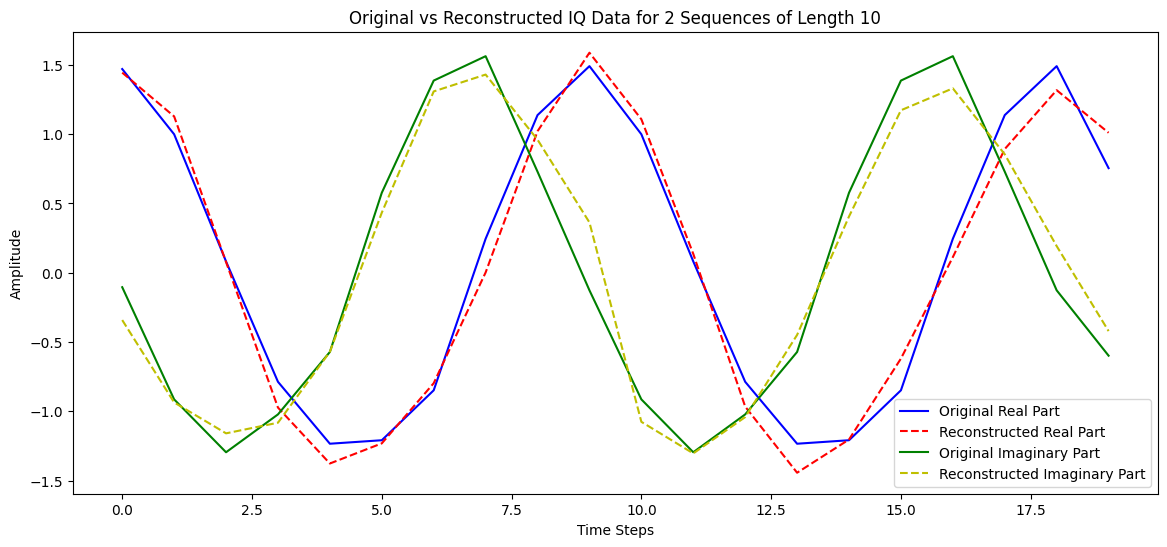

In [5]:
# # Define the number of sequences to plot together
n = 9  # Change this to desired number of sequences
sample_length = sequence_length * n

# Select a random starting sequence for plotting
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)

# Extract and concatenate the original and reconstructed samples
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

# Plot concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
# plt.plot(original_sample[:, 1], 'orange', label='Original Real STD')
# plt.plot(reconstructed_sample[:, 1], 'orange', label='Reconstructed Real STD', linestyle='--')

plt.plot(original_sample[:, 1], 'y-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'g--', label='Reconstructed Imaginary Part')
# plt.plot(original_sample[:, 5], 'pink', label='Original Imaginary STD')
# plt.plot(reconstructed_sample[:, 5], 'pink', label='Reconstructed Imaginary STD', linestyle='--')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('9-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

# Repeat for n = 9
n = 2  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

z_mean.shape: (390, 25)
z_log_var.shape: (390, 25)


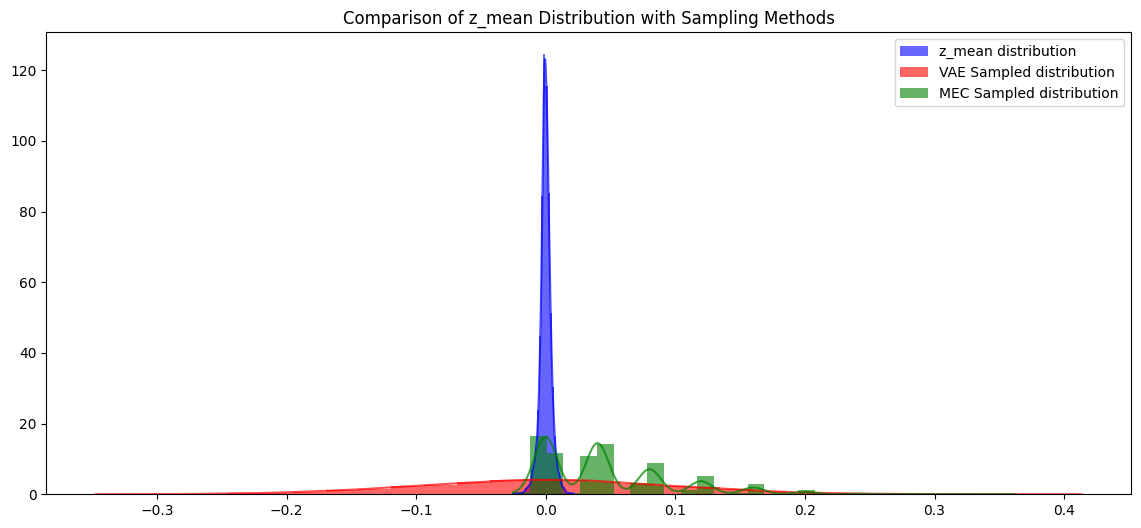

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns

# Ensure compatibility for TensorFlow 2.x
tf.compat.v1.enable_eager_execution()
epsilon_std = 0.1

# Dummy data assuming z_mean and z_log_var have been obtained
# z_mean = tf.random.normal([100, 50])  # 100 samples, 50 dimensions
# z_log_var = tf.random.normal([100, 50])
print('z_mean.shape:', z_mean.shape)
print('z_log_var.shape:', z_log_var.shape)
z_mean = collected_z_means[0]  # Using only the first batch
z_log_var = collected_z_log_var[0]
z = collected_z[0]

# Simplified version of your model's sampling functions for visualization purposes
def sample_vae(z_mean, z_log_var, epsilon_std=0.1):
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim), mean=0., stddev=epsilon_std)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

#mec_layer = MECTransformationLayer(latent_dim=25)  # Update the latent_dim if needed

# def sample_mec(z_mean, z_log_var, z_input):
#     batch = tf.shape(z_mean)[0]
#     dim = tf.shape(z_mean)[1]
#     epsilon = tf.random.normal(shape=(batch, dim), mean=0., stddev=0.1)
#     z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
#     # Apply the MEC transformation using the instantiated layer
#     # Ensure the input is [z_input, z], both must have the same shape
#     #z_input = z_mean  # For demonstration, using z_mean as z_input, adjust based on your model's specifics
#     z_mec = mec_layer([z_input, z])  # The layer expects a list of two tensors
#     return z_mec
def sample_mec(z_mean, z_log_var):
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=epsilon_std)
        # Standard reparameterization trick
        z = z_mean + K.exp(0.5 * z_log_var) * epsilon
        # Consider z_mean as x and z as y for MEC application
        z_mec = apply_mec_to_data(z_mean, z)
        # Convert z_mec to float32 to match z_mean and z_log_var
        z_mec = tf.cast(z_mec, dtype=tf.float32)
        z_mec = z_mean + K.exp(0.5 * z_log_var) * z_mec
        return z_mec
# Function to plot distributions
def plot_distribution(tensor, label, color):
    #print('tensor:', tensor)
    if isinstance(tensor, tf.Tensor):
        tensor = tensor.numpy()  # Convert TensorFlow tensor to numpy array
    tensor = tensor.flatten()  # Flatten the tensor/array
    
    plt.hist(tensor, bins=30, density=True, alpha=0.6, label=label, color=color)
    
    kde = gaussian_kde(tensor)
    kde_x = np.linspace(tensor.min(), tensor.max(), 500)
    kde_y = kde.evaluate(kde_x)
    plt.plot(kde_x, kde_y, color=color, alpha=0.7)
    
# Generate samples
z_sampled_vae = sample_vae(z_mean, z_log_var)
z_sampled_mec = sample_mec(z_mean, z_log_var)
z_collected_mec = collected_z[0]

# Visualization
# plt.figure(figsize=(14, 6))
# plot_distribution(z_mean.flatten(), "z_mean distribution", "blue")
# plot_distribution(z_input.numpy().flatten(), "z sampled VAE distribution", "red")
# plot_distribution(z_sampled_mec.numpy().flatten(), "z_mec distribution", "green")

# plt.legend()
# plt.title('Latent Variable Distributions Before and After Sampling')
# plt.show()


plt.figure(figsize=(14, 6))
plot_distribution(z_mean.flatten(), "z_mean distribution", "blue")
plot_distribution(z_sampled_vae.numpy().flatten(), "VAE Sampled distribution", "red")
plot_distribution(z_sampled_mec.numpy().flatten(), "MEC Sampled distribution", "green")

plt.legend()
plt.title('Comparison of z_mean Distribution with Sampling Methods')
plt.show()

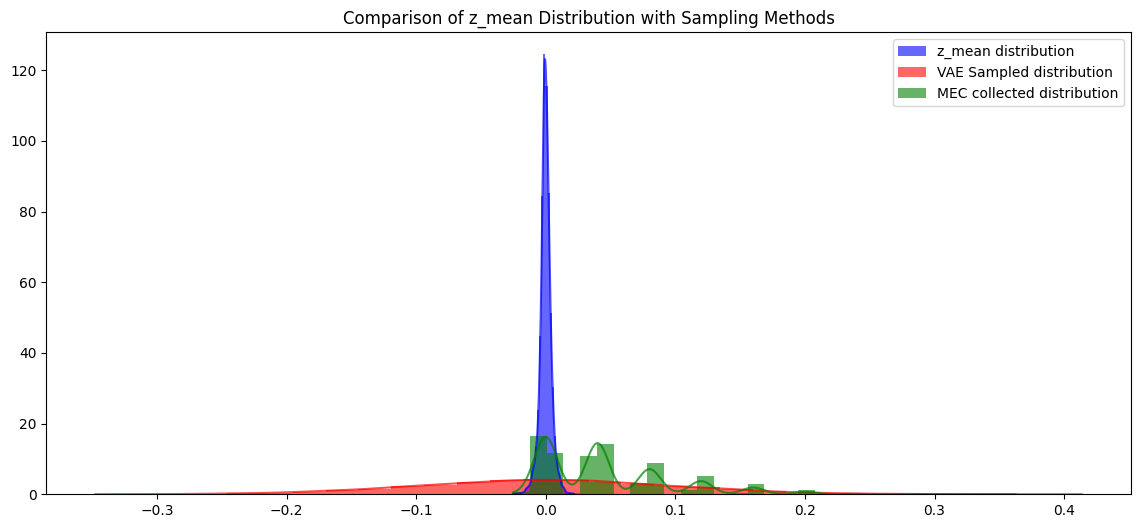

In [7]:
plt.figure(figsize=(14, 6))
plot_distribution(z_mean.flatten(), "z_mean distribution", "blue")
plot_distribution(z_sampled_vae.numpy().flatten(), "VAE Sampled distribution", "red")
plot_distribution(z_collected_mec.flatten(), "MEC collected distribution", "green")

plt.legend()
plt.title('Comparison of z_mean Distribution with Sampling Methods')
plt.show()

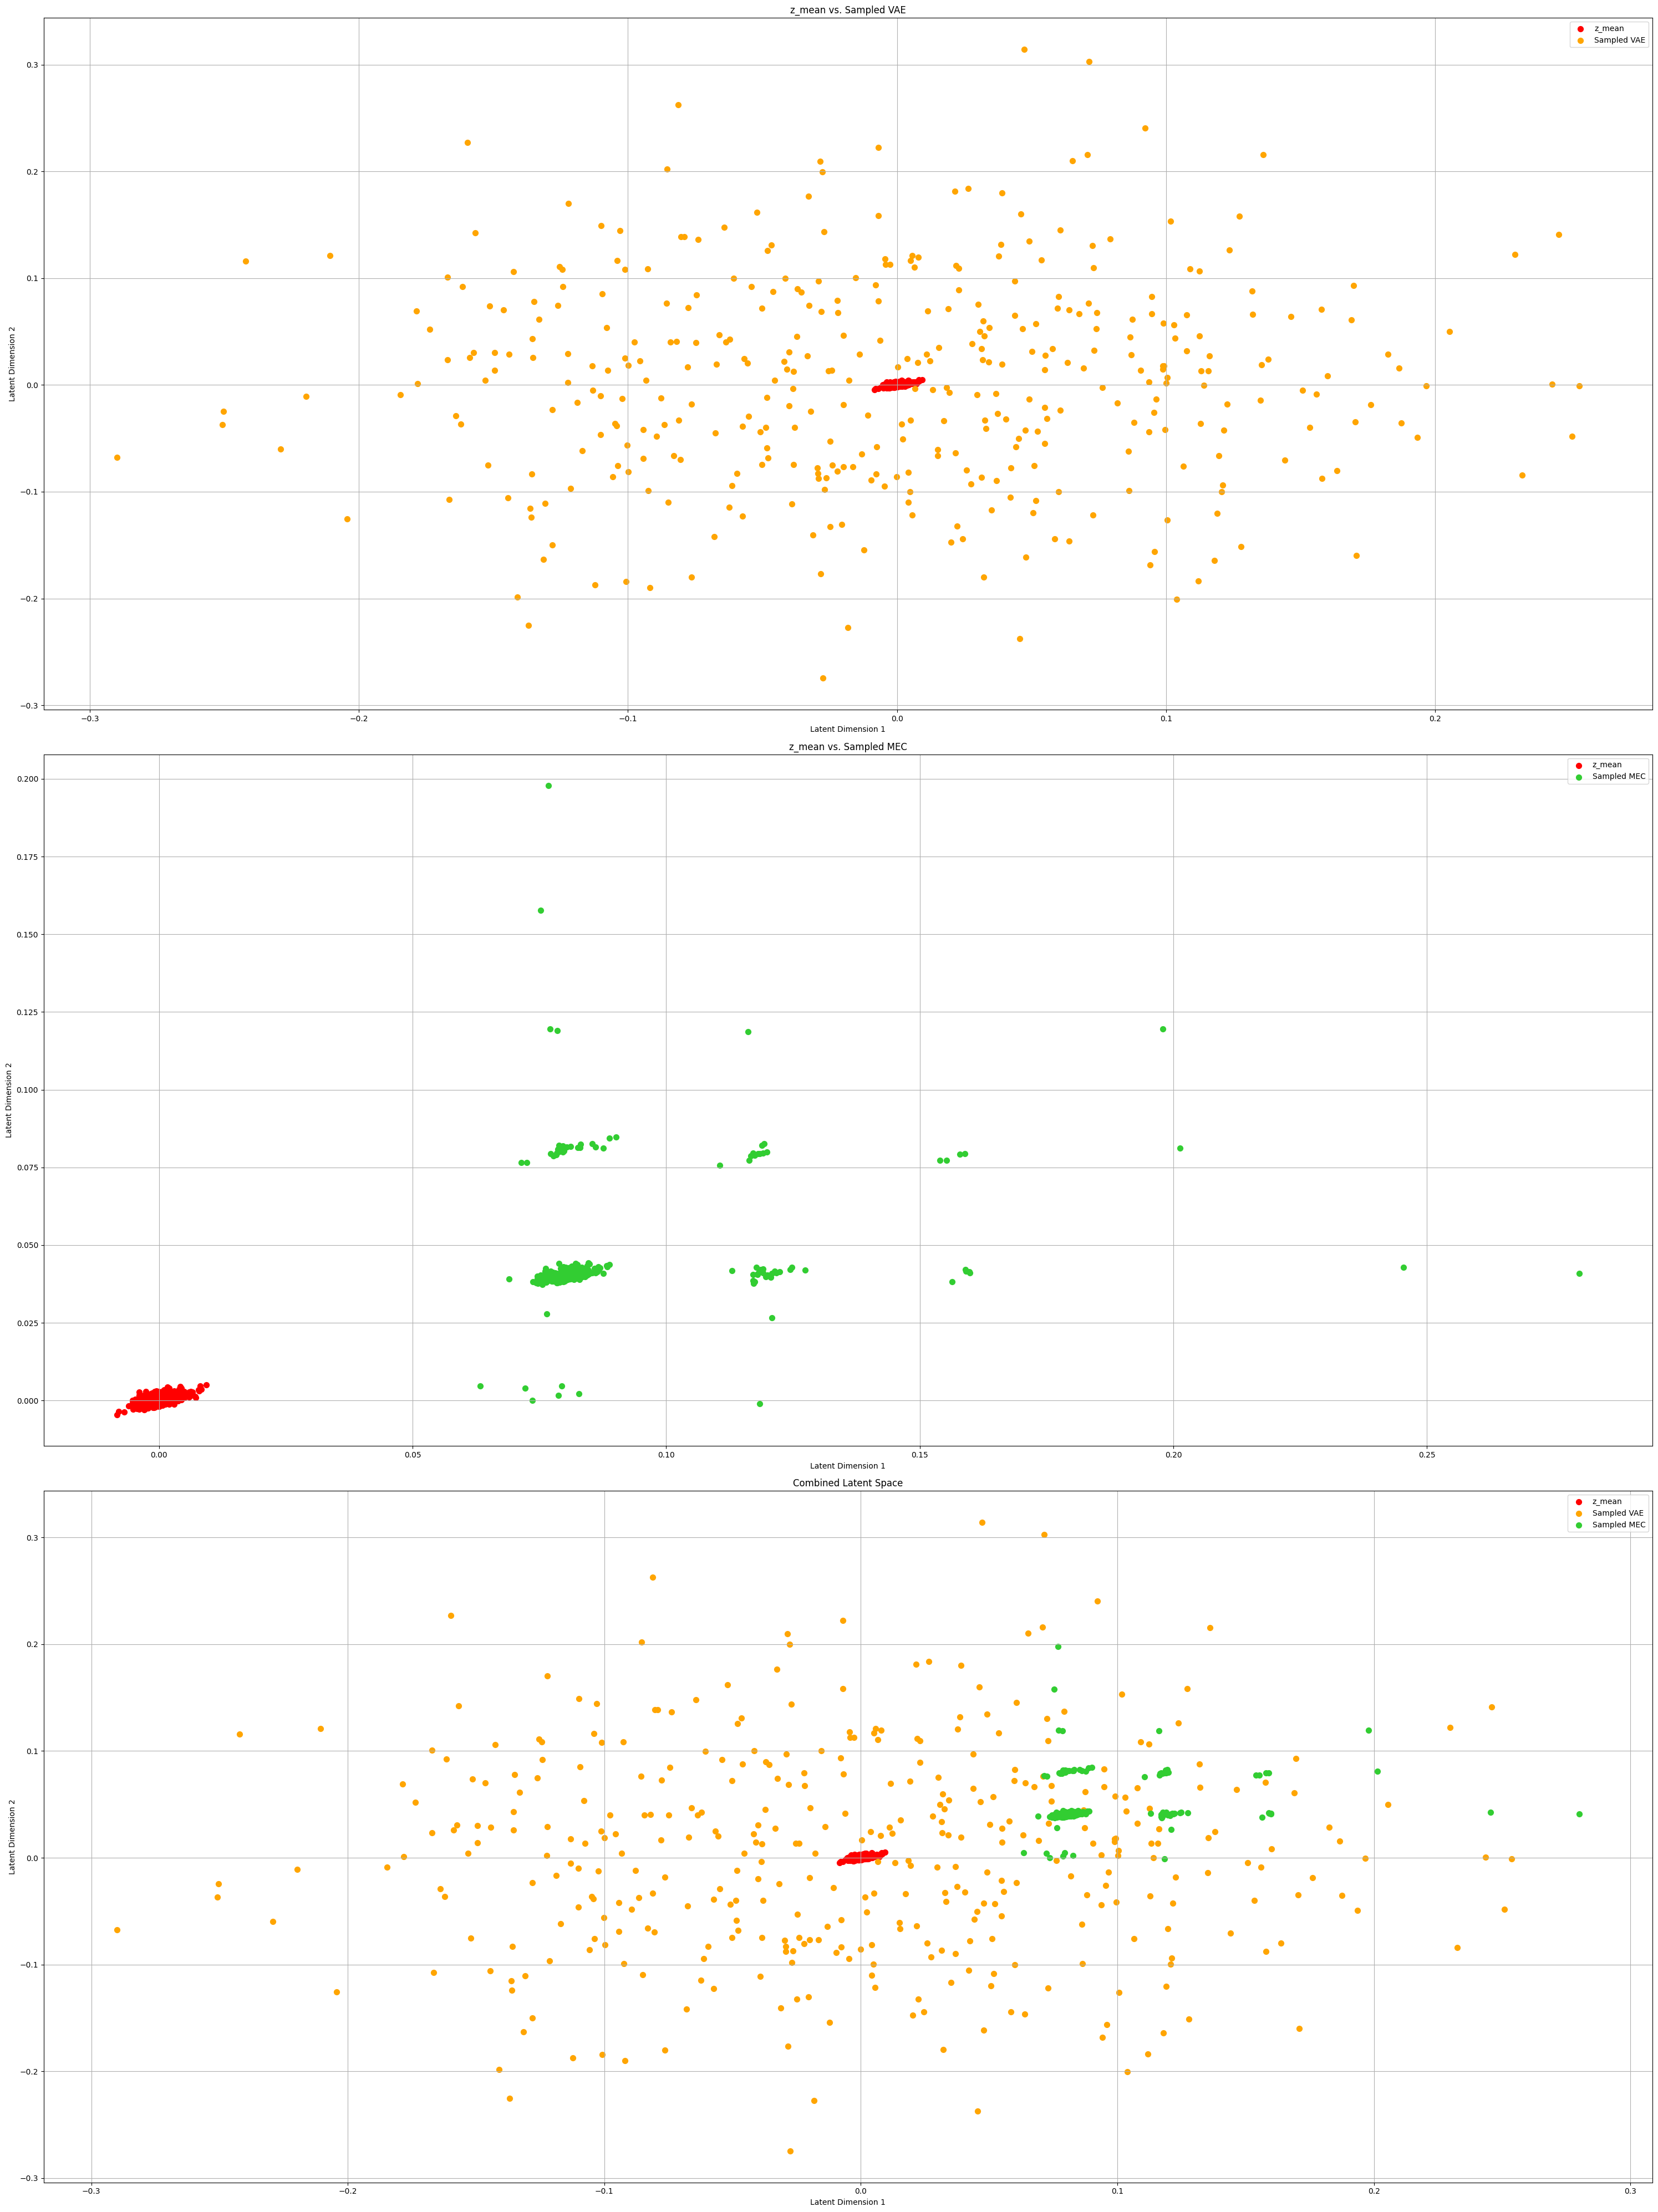

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def extract_first_two_dimensions(latent_vars):
    return latent_vars[:, :2]  # Extract first two dimensions and convert to numpy

# Prepare the latent variables
z_mean_2d = extract_first_two_dimensions(z_mean)
z_sampled_vae_2d = extract_first_two_dimensions(z_sampled_vae)
z_sampled_mec_2d = extract_first_two_dimensions(z_sampled_mec)

def scatter_plots(latent_variables, labels, titles):
    # Set up a figure with three subplots
    fig, axs = plt.subplots(3, 1, figsize=(30, 40))
    colors = ['red', 'orange', 'limegreen']

    # First plot: z_mean vs. Sampled VAE
    axs[0].scatter(latent_variables[:, 0, 0], latent_variables[:, 0, 1], color='red', s=50, label='z_mean')
    axs[0].scatter(latent_variables[:, 1, 0], latent_variables[:, 1, 1], color='orange', s=50, label='Sampled VAE')
    axs[0].set_title(titles[0])
    axs[0].legend()
    axs[0].grid(True)

    # Second plot: z_mean vs. Sampled MEC
    axs[1].scatter(latent_variables[:, 0, 0], latent_variables[:, 0, 1], color='red', s=50, label='z_mean')
    axs[1].scatter(latent_variables[:, 2, 0], latent_variables[:, 2, 1], color='limegreen', s=50, label='Sampled MEC')
    axs[1].set_title(titles[1])
    axs[1].legend()
    axs[1].grid(True)

    # Third plot: Combined Latent Space
    axs[2].scatter(latent_variables[:, 0, 0], latent_variables[:, 0, 1], color='red', s=50, label='z_mean')
    axs[2].scatter(latent_variables[:, 1, 0], latent_variables[:, 1, 1], color='orange', s=50, label='Sampled VAE')
    axs[2].scatter(latent_variables[:, 2, 0], latent_variables[:, 2, 1], color='limegreen', s=50, label='Sampled MEC')
    axs[2].set_title(titles[2])
    axs[2].legend()
    axs[2].grid(True)

    # Set axes labels
    for ax in axs:
        ax.set_xlabel('Latent Dimension 1')
        ax.set_ylabel('Latent Dimension 2')

    plt.tight_layout()
    plt.show()

# Prepare the latent variables for plotting
latent_variables = np.stack([z_mean_2d, z_sampled_vae_2d, z_sampled_mec_2d], axis=1)
labels = ['z_mean', 'Sampled VAE', 'Sampled MEC']
titles = ['z_mean vs. Sampled VAE', 'z_mean vs. Sampled MEC', 'Combined Latent Space']

# Call the plotting function
scatter_plots(latent_variables, labels, titles)


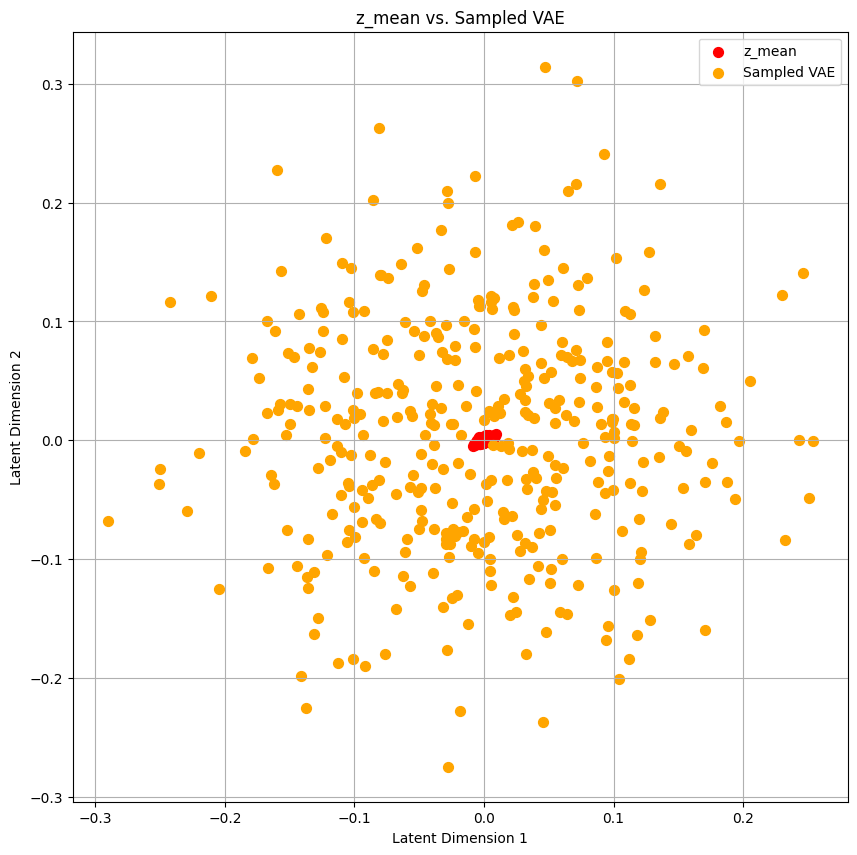

In [9]:
import matplotlib.pyplot as plt

def plot_z_mean_vs_sampled_vae(z_mean_2d, z_sampled_vae_2d):
    plt.figure(figsize=(10, 10))
    plt.scatter(z_mean_2d[:, 0], z_mean_2d[:, 1], color='red', s=50, label='z_mean')
    plt.scatter(z_sampled_vae_2d[:, 0], z_sampled_vae_2d[:, 1], color='orange', s=50, label='Sampled VAE')
    plt.title('z_mean vs. Sampled VAE')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function
plot_z_mean_vs_sampled_vae(z_mean_2d, z_sampled_vae_2d)


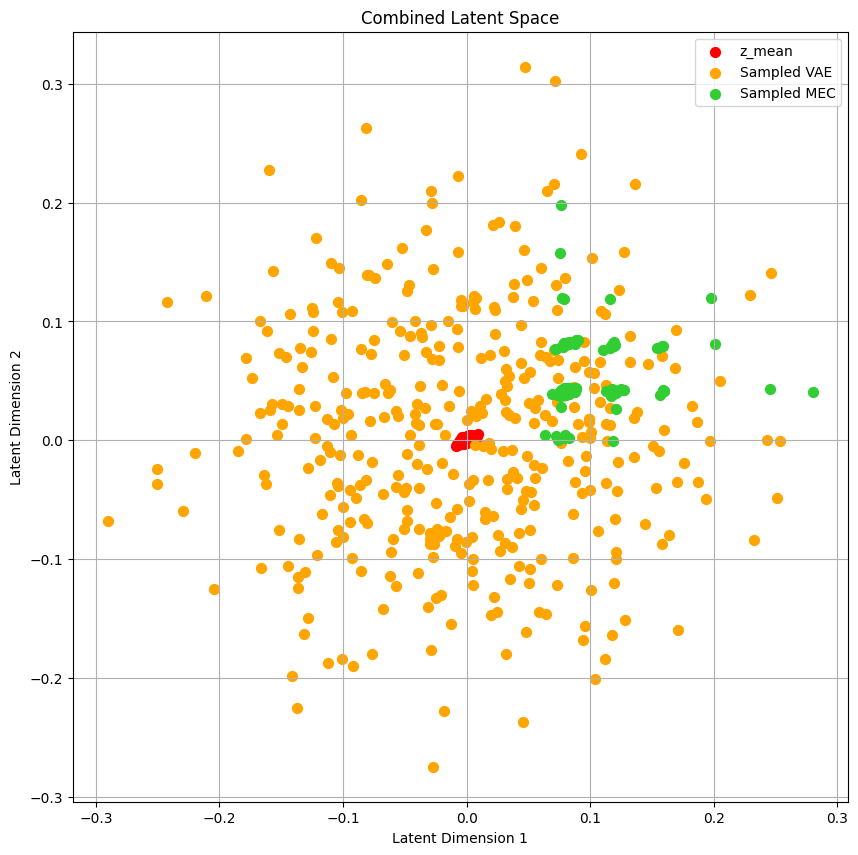

In [10]:
def plot_combined_latent_space(z_mean_2d, z_sampled_vae_2d, z_sampled_mec_2d):
    plt.figure(figsize=(10, 10))
    plt.scatter(z_mean_2d[:, 0], z_mean_2d[:, 1], color='red', s=50, label='z_mean')
    plt.scatter(z_sampled_vae_2d[:, 0], z_sampled_vae_2d[:, 1], color='orange', s=50, label='Sampled VAE')
    plt.scatter(z_sampled_mec_2d[:, 0], z_sampled_mec_2d[:, 1], color='limegreen', s=50, label='Sampled MEC')
    plt.title('Combined Latent Space')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function
plot_combined_latent_space(z_mean_2d, z_sampled_vae_2d, z_sampled_mec_2d)


Epoch 1/4
Step 1/2500, Loss: 1.0015285015106201
Step 201/2500, Loss: 0.9613143801689148
Step 401/2500, Loss: 0.9253177642822266
Step 601/2500, Loss: 0.9019365906715393
Step 801/2500, Loss: 0.9056737422943115
Step 1001/2500, Loss: 0.8767286539077759
Step 1201/2500, Loss: 0.30407461524009705
Step 1401/2500, Loss: 0.37393897771835327
Step 1601/2500, Loss: 0.7909435033798218
Step 1801/2500, Loss: 0.8121302723884583
Step 2001/2500, Loss: 0.10984699428081512
Step 2201/2500, Loss: 0.7532879114151001
Step 2401/2500, Loss: 0.7015301585197449
Step 2500/2500
Epoch 2/4
Step 1/2500, Loss: 0.6980454921722412
Step 201/2500, Loss: 0.03020865097641945
Step 401/2500, Loss: 0.01666138507425785
Step 601/2500, Loss: 0.625747799873352
Step 801/2500, Loss: 0.5963187217712402
Step 1001/2500, Loss: 0.05804598703980446
Step 1201/2500, Loss: 0.679071307182312
Step 1401/2500, Loss: 0.6130154132843018
Step 1601/2500, Loss: 0.015033315867185593
Step 1801/2500, Loss: 0.018330035731196404
Step 2001/2500, Loss: 0.5970

13/13 [==============================] - 0s 2ms/step
prediction number: 79
13/13 [==============================] - 0s 2ms/step
prediction number: 80
13/13 [==============================] - 0s 2ms/step
prediction number: 81
13/13 [==============================] - 0s 2ms/step
prediction number: 82
13/13 [==============================] - 0s 2ms/step
prediction number: 83
13/13 [==============================] - 0s 2ms/step
prediction number: 84
13/13 [==============================] - 0s 2ms/step
prediction number: 85
13/13 [==============================] - 0s 2ms/step
prediction number: 86
13/13 [==============================] - 0s 2ms/step
prediction number: 87
13/13 [==============================] - 0s 2ms/step
prediction number: 88
13/13 [==============================] - 0s 2ms/step
prediction number: 89
13/13 [==============================] - 0s 2ms/step
prediction number: 90
13/13 [==============================] - 0s 2ms/step
prediction number: 91
13/13 [==================

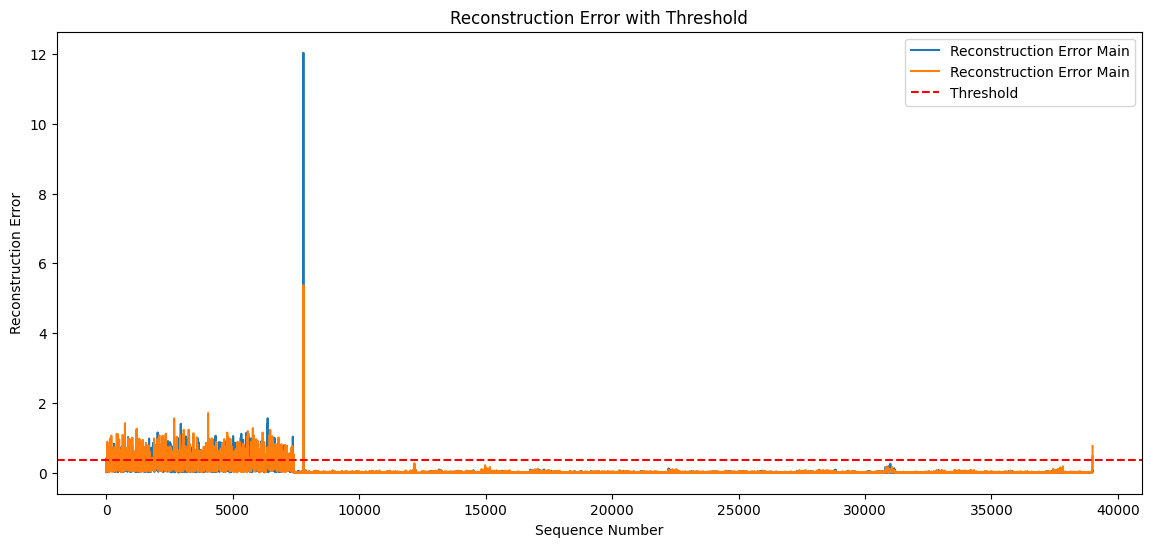

In [11]:

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
import matplotlib.pyplot as plt
import os
import struct

def load_data(filepath):
    _, file_extension = os.path.splitext(filepath)
    
    if file_extension == '.csv':
        df = pd.read_csv(filepath)
        samples = df['your_column_name'].values
    elif file_extension == '.dat':
        #Looks like DAT is binary encoded added a b in r as rb
        with open(filepath, 'rb') as f:
            samples = f.readlines()
        samples = np.array([sample.strip() for sample in samples])
    else:
        raise ValueError(f"Unsupported file format: {file_extension}")
    
    return samples

def count_lines(filepath):
    with open(filepath, 'rb') as f:
        return sum(1 for _ in f)


class DataGenerator:        
    def __init__(self, filepath, batch_size, sequence_length, max_samples=None, for_training=True):
        self.filepath = filepath
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.max_samples = max_samples
        self.for_training = for_training
        self.samples = []
        self.binary_file = open(self.filepath, 'rb')  # Initialize the binary_file here
        self.reset()

    def reset(self):
        self.total_samples_processed = 0
        _, self.file_extension = os.path.splitext(self.filepath)


    def __iter__(self):
        self.binary_file.seek(0)  # reset file pointer
        self.samples = []
        return self
    
    def close(self):
        if not self.binary_file.closed:
            self.binary_file.close()

    def process_data(self, samples):
        real_parts = []
        imag_parts = []
        for sample in samples:
            try:
                cnum = complex(sample.replace('j', 'j'))
                real_parts.append(np.real(cnum))
                imag_parts.append(np.imag(cnum))
            except ValueError:
                continue

        real_parts = (real_parts - np.mean(real_parts)) / np.std(real_parts)
        imag_parts = (imag_parts - np.mean(imag_parts)) / np.std(imag_parts)

        X = [list(zip(real_parts[i:i+self.sequence_length], imag_parts[i:i+self.sequence_length])) for i in range(len(real_parts) - self.sequence_length)]
        return np.array(X)

    def __next__(self):
        chunksize = self.batch_size * self.sequence_length
        samples = []
        while True:
            binary_data = self.binary_file.read(8)
            if not binary_data:
                break 
            decoded_data = struct.unpack('ff', binary_data)
            if decoded_data[0] == 0 and decoded_data[1] == 0:
                decoded_line = f"0j\n"
            else:
                if decoded_data[1] >= 0:
                    decoded_line = f"{decoded_data[0]}+{decoded_data[1]}j\n"
                else:
                    decoded_line = f"{decoded_data[0]}{decoded_data[1]}j\n"
            samples.append(decoded_line)

            if self.max_samples and self.total_samples_processed >= self.max_samples:
                raise StopIteration
            self.total_samples_processed += 1
            #print('samples:', samples)
            if len(samples) == chunksize:
                X_chunk = self.process_data(samples)
                #print('X_chunk:', X_chunk)
                if self.for_training:
                    return X_chunk, X_chunk
                else:
                    return X_chunk
                samples = []

#         if self.file_extension == '.dat':
#             samples = []
#             while True:
#                 binary_data = self.binary_file.read(8)
#                 if not binary_data:
#                     break 
#                 decoded_data = struct.unpack('ff', binary_data)
#                 if decoded_data[0] == 0 and decoded_data[1] == 0:
#                     decoded_line = f"0j\n"
#                 else:
#                     if decoded_data[1] >= 0:
#                         decoded_line = f"{decoded_data[0]}+{decoded_data[1]}j\n"
#                     else:
#                         decoded_line = f"{decoded_data[0]}{decoded_data[1]}j\n"
#                 samples.append(decoded_line)

#                 if self.max_samples and self.total_samples_processed >= self.max_samples:
#                     raise StopIteration
#                 self.total_samples_processed += 1
#                 #print('samples:', samples)
#                 if len(samples) == chunksize:
#                     X_chunk = self.process_data(samples)
#                     #print('X_chunk:', X_chunk)
#                     if self.for_training:
#                         return X_chunk, X_chunk
#                     else:
#                         return X_chunk
#                     samples = []

        
#         else:
#             raise StopIteration


#in RNN: we should determine the number of consecutive samples grouped together as a single input 
#sequence for the RNN, so the model will take the first N samples as input 
#and try to reconstruct them.

sequence_length = 10

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 2), return_sequences=True))
model.add(LSTM(25, activation='relu', return_sequences=False))
model.add(RepeatVector(sequence_length))
model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(2)))

model.compile(optimizer='adam', loss='mse')

# first I need to train pure data batch by batch

batch_size = 40
num_pure_samples = count_lines('/home/mreza/5G accelerator/models/5G_DL_IQ_no_jamming_0924.dat')
#print('num_pure_samples:', num_pure_samples)

max_train_samples = 1000000  # I limit the train or can put None for whole data
train_steps = (min(num_pure_samples, max_train_samples) if 
               max_train_samples else num_pure_samples) // (batch_size * sequence_length)

pure_file_new = '/home/mreza/5G accelerator/ID_MEC/data generator/New Data-Collection/rx_IQ_pure'
mixed_file_new = '/home/mreza/5G accelerator/ID_MEC/data generator/New Data-Collection/rx_IQ_MIX'
train_gen_instance = DataGenerator(pure_file_new, 
                                   batch_size=batch_size, sequence_length=sequence_length, 
                                   max_samples=max_train_samples, for_training=True)

# Modify training loop
num_epochs = 4
steps_per_epoch = train_steps  
losses_simple_model = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_gen_instance.reset()  # Reset the generator at the beginning of each epoch
    for step in range(steps_per_epoch):
        try:
            X_chunk, Y_chunk = next(train_gen_instance)
        except StopIteration:
            train_gen_instance.reset()  # Reset the generator when it runs out of data
            X_chunk, Y_chunk = next(train_gen_instance)

        #model.train_on_batch(X_chunk, Y_chunk)
        loss = model.train_on_batch(X_chunk, Y_chunk)
        losses_simple_model.append(loss)
        print(f"Step {step + 1}/{steps_per_epoch}", end='\r')
        if step % 200 == 0:
            print(f"Step {step + 1}/{train_steps}, Loss: {loss}")
    print()

combined_gen_instance = DataGenerator(mixed_file_new, 
                                      batch_size=batch_size, sequence_length=sequence_length, 
                                      for_training=False)


num_samples = count_lines('/home/mreza/5G accelerator/models/5G_DL_IQ_with_periodic_jamming_0928_02.dat')
max_predictions = num_samples // (batch_size * sequence_length)

num_predictions = 100  # or any other large number
num_predictions = min(num_predictions, max_predictions)

print(f"Maximum number of predictions available: {max_predictions}")
print(f"Number of predictions to be performed: {num_predictions}")

reconstruction_errors_main = []
try:
    for _ in range(num_predictions):
        print('prediction number:', _)
        X_chunk_test = next(combined_gen_instance)
        X_chunk_pred = model.predict(X_chunk_test)
        chunk_errors = np.mean(np.square(X_chunk_test - X_chunk_pred), axis=1)
        reconstruction_errors_main.extend(chunk_errors)
except StopIteration:
    print("All samples processed.")
        
reconstruction_errors_main = np.array(reconstruction_errors_main)
print("Reconstruction error main calculated.")

# set threshold
threshold_main = np.percentile(reconstruction_errors_main, 95)
print('threshold_main:', threshold_main)

jamming_detected_main = reconstruction_errors_main > threshold_main
print('jamming_detected_main:', jamming_detected_main)

train_gen_instance.close()
combined_gen_instance.close()

#Table to get insight
flattened_jamming_detected_main = jamming_detected_main.flatten()

real_part_detected_main = jamming_detected_main[:, 0]
imag_part_detected_main = jamming_detected_main[:, 1]

real_true_count_main = np.sum(real_part_detected_main)
real_false_count_main = len(real_part_detected_main) - real_true_count_main

imag_true_count_main = np.sum(imag_part_detected_main)
imag_false_count_main = len(imag_part_detected_main) - imag_true_count_main

# Overall
overall_true_count_main = np.sum(flattened_jamming_detected_main)
overall_false_count_main = len(flattened_jamming_detected_main) - overall_true_count_main

# Table-DataFrame
df_actual = pd.DataFrame({
    'Part': ['Real', 'Imaginary', 'Overall'],
    'True Count': [real_true_count_main, imag_true_count_main, overall_true_count_main],
    'False Count': [real_false_count_main, imag_false_count_main, overall_false_count_main]
})

print(df_actual)

num_jamming_detected_main = np.sum(jamming_detected_main)
print(f"Number of jamming sequences detected: {num_jamming_detected_main} out of {len(flattened_jamming_detected_main)} sequences")


# reconstruction error
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_errors_main, label='Reconstruction Error Main')
plt.axhline(y=threshold_main, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()




Length of true labels: 78000
Length of predicted labels: 78000
Confusion Matrix:
[[73483   617]
 [ 3684   216]]
ROC AUC: 0.5235290148448043
              precision    recall  f1-score   support

       False       0.95      0.99      0.97     74100
        True       0.26      0.06      0.09      3900

    accuracy                           0.94     78000
   macro avg       0.61      0.52      0.53     78000
weighted avg       0.92      0.94      0.93     78000



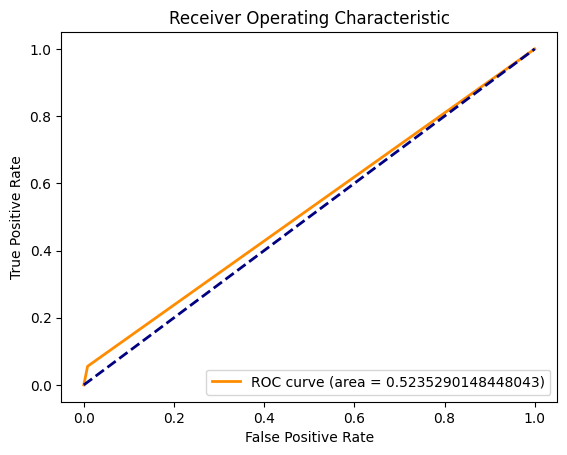

In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

true_labels = flattened_jamming_detected_main
predicted_labels = flattened_jamming_detected
#predicted_labels = np.array(reconstruction_errors > threshold2, dtype=int).flatten()

# Verify lengths and shapes
print("Length of true labels:", len(true_labels))
print("Length of predicted labels:", len(predicted_labels))


try:
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    roc_auc = roc_auc_score(true_labels, predicted_labels)
    fpr, tpr, _ = roc_curve(true_labels, predicted_labels)
    report = classification_report(true_labels, predicted_labels)

    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"ROC AUC: {roc_auc}")
    print(report)

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
except Exception as e:
    print("Error in calculating metrics:", e)

Confusion Matrix:
[[73483   617]
 [ 3684   216]]
Accuracy: 0.9448589743589744
Precision: 0.25930372148859543
Recall: 0.055384615384615386
ROC AUC: 0.5235290148448043


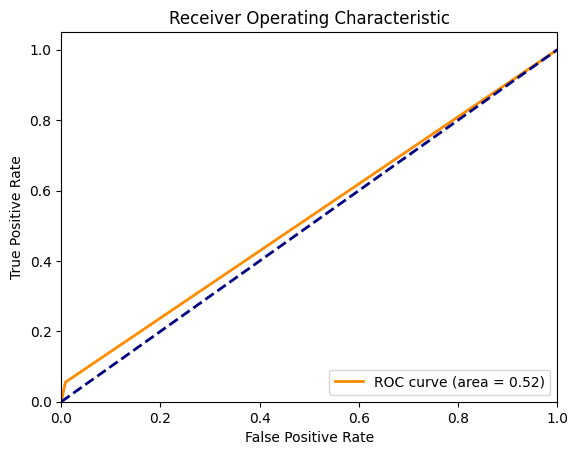

In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming df_predicted and df_actual have the same structure as shown in your example

# Extracting the true labels and predicted labels
actual_labels = flattened_jamming_detected_main
predicted_labels = flattened_jamming_detected

# Confusion Matrix
cm = confusion_matrix(actual_labels, predicted_labels)
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels)
recall = recall_score(actual_labels, predicted_labels)
roc_auc = roc_auc_score(actual_labels, predicted_labels)

print(f"Confusion Matrix:\n{cm}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC AUC: {roc_auc}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(actual_labels, predicted_labels)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


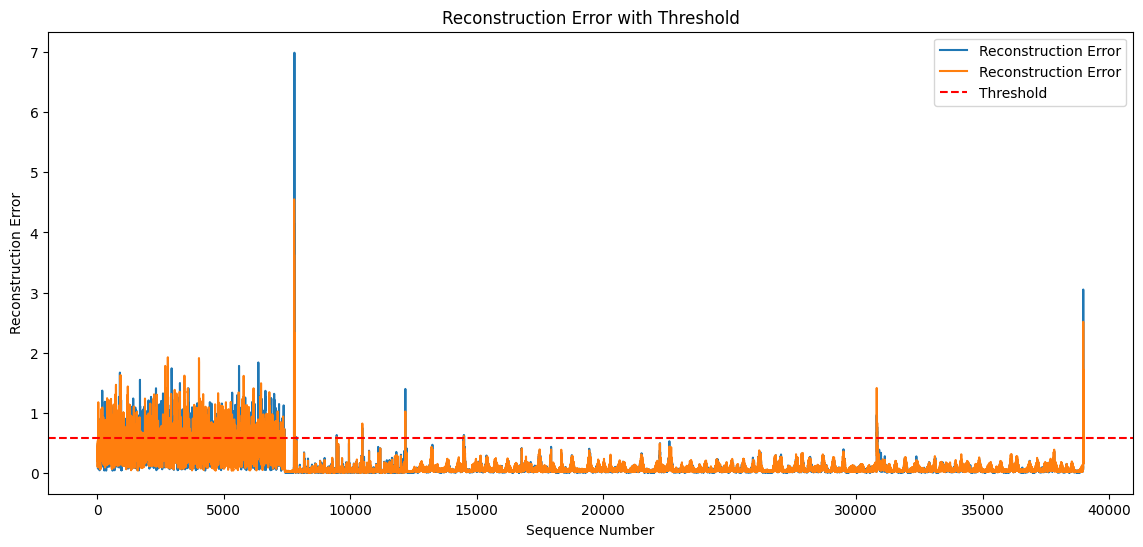

In [14]:

# reconstruction error
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('1-Reconstruction Error with Threshold.png')
# plt.close()
plt.show()

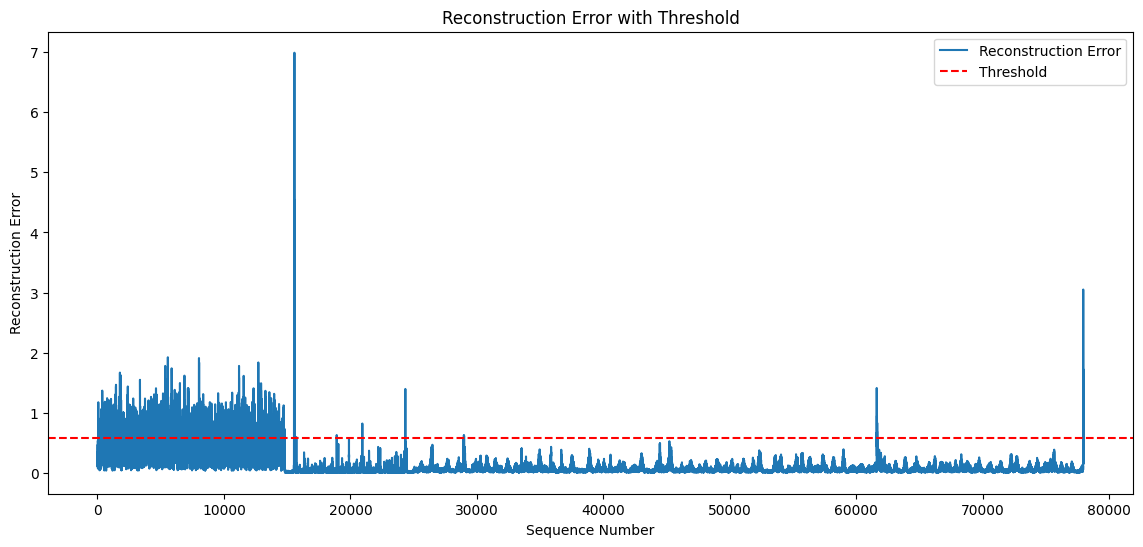

In [15]:
# Flatten the reconstruction_error to 1D
reconstruction_error_flat = reconstruction_error.flatten()
# reconstruction error
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error_flat, label='Reconstruction Error')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('1-Reconstruction Error with Threshold.png')
# plt.close()
plt.show()


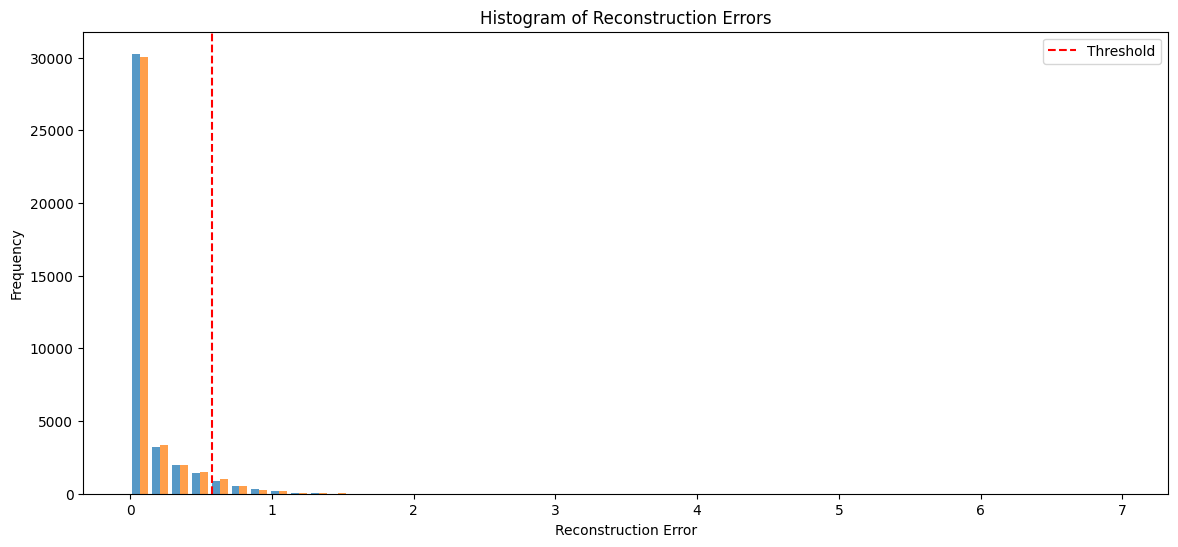

In [16]:
#Histogram of Reconstruction Errors:
plt.figure(figsize=(14, 6))
plt.hist(reconstruction_error, bins=50, alpha=0.75)
plt.axvline(x=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('4-Histogram of Reconstruction Errors.png')
# plt.close()
plt.show()


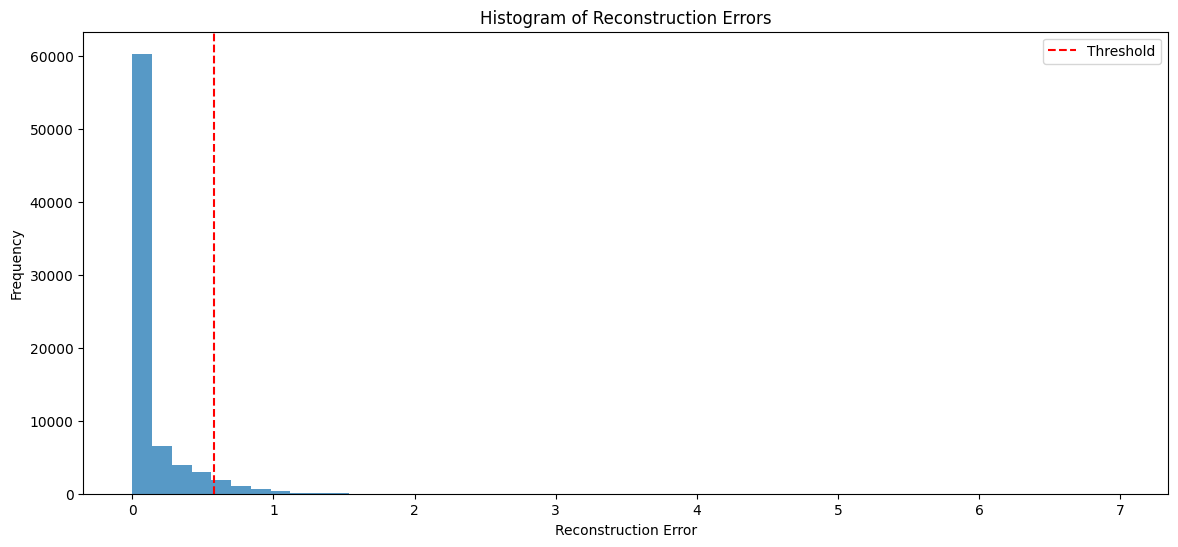

In [17]:
# Flatten the reconstruction_error to 1D
reconstruction_error_flat = reconstruction_error.flatten()
#Histogram of Reconstruction Errors:
plt.figure(figsize=(14, 6))
plt.hist(reconstruction_error_flat, bins=50, alpha=0.75)
plt.axvline(x=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('4-Histogram of Reconstruction Errors.png')
# plt.close()
plt.show()

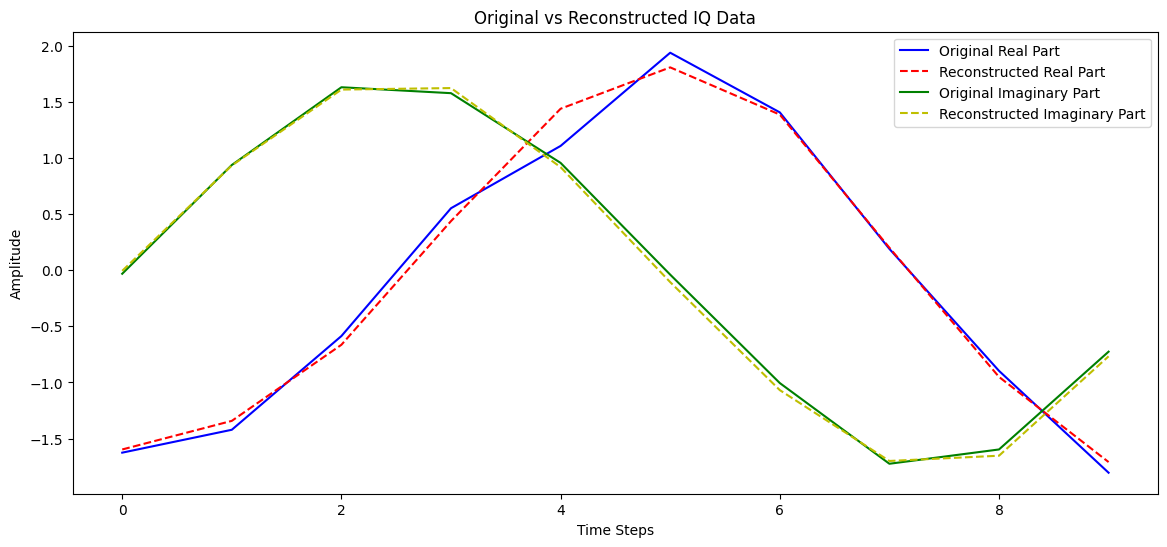

In [18]:
#Time Series Plot of IQ Samples:
sample_index = np.random.choice(len(X_chunk_test))
original_sample = X_chunk_test[sample_index]
reconstructed_sample = X_chunk_pred[sample_index]

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title('Original vs Reconstructed IQ Data')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('5-Original vs Reconstructed IQ Data.png')
# plt.close()
plt.show()


Shape of avg_real: (390,)
Shape of avg_imag: (390,)
Shape of last_errors: 390


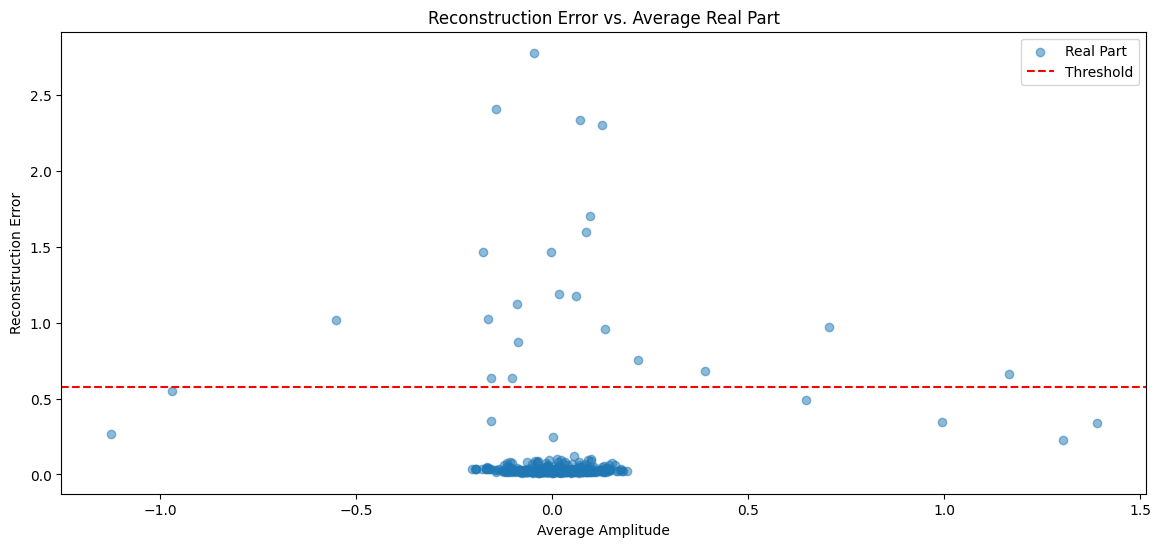

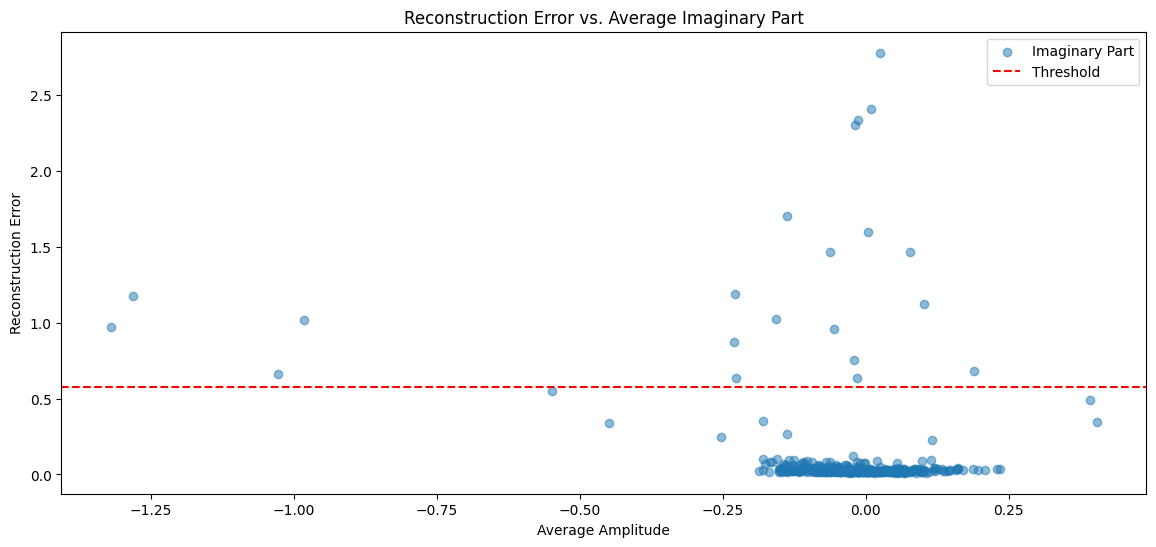

In [19]:
#Scatter Plot of Reconstruction Errors vs. Real and Imaginary Parts:
avg_real = np.mean(X_chunk_test, axis=1)[:, 0]
avg_imag = np.mean(X_chunk_test, axis=1)[:, 1]

last_errors = np.mean(reconstruction_errors[-len(X_chunk_test):], axis=1)

print("Shape of avg_real:", avg_real.shape)
print("Shape of avg_imag:", avg_imag.shape)
print("Shape of last_errors:", len(last_errors))


plt.figure(figsize=(14, 6))
plt.scatter(avg_real, last_errors, label='Real Part', alpha=0.5)
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error vs. Average Real Part')
plt.xlabel('Average Amplitude')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('6-Reconstruction Error vs. Average Real Part.png')
# plt.close()
plt.show()

plt.figure(figsize=(14, 6))
plt.scatter(avg_imag, last_errors, label='Imaginary Part', alpha=0.5)
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error vs. Average Imaginary Part')
plt.xlabel('Average Amplitude')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('7-Reconstruction Error vs. Average Imaginary Part.png')
# plt.close()
plt.show()

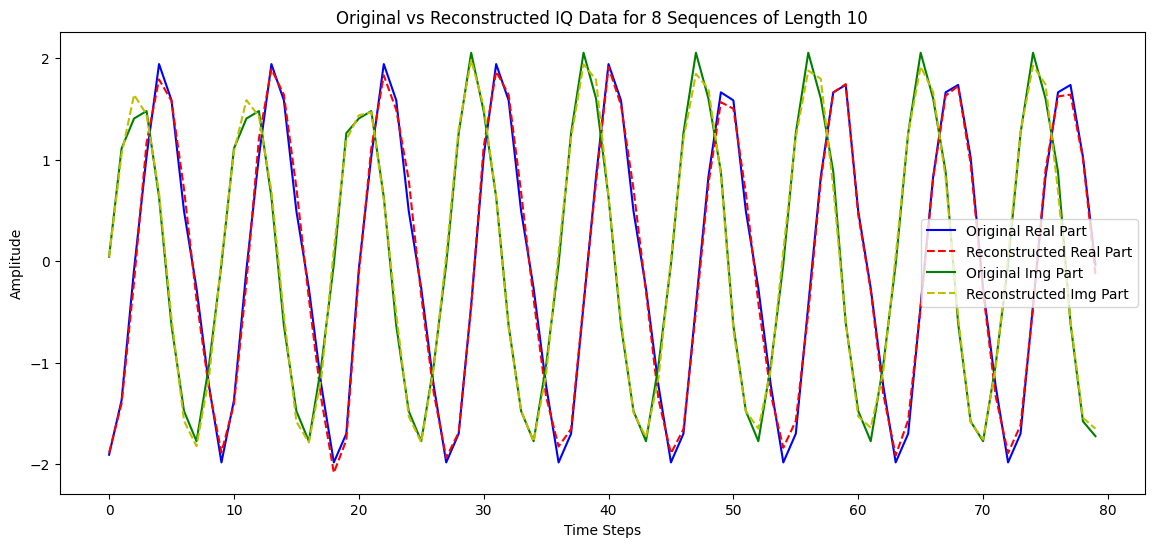

In [20]:
# # Define the number of sequences to plot together
n = 8  # Change this to desired number of sequences
sample_length = sequence_length * n

# Select a random starting sequence for plotting
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)

# Extract and concatenate the original and reconstructed samples
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

# Plot concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Img Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Img Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('9-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

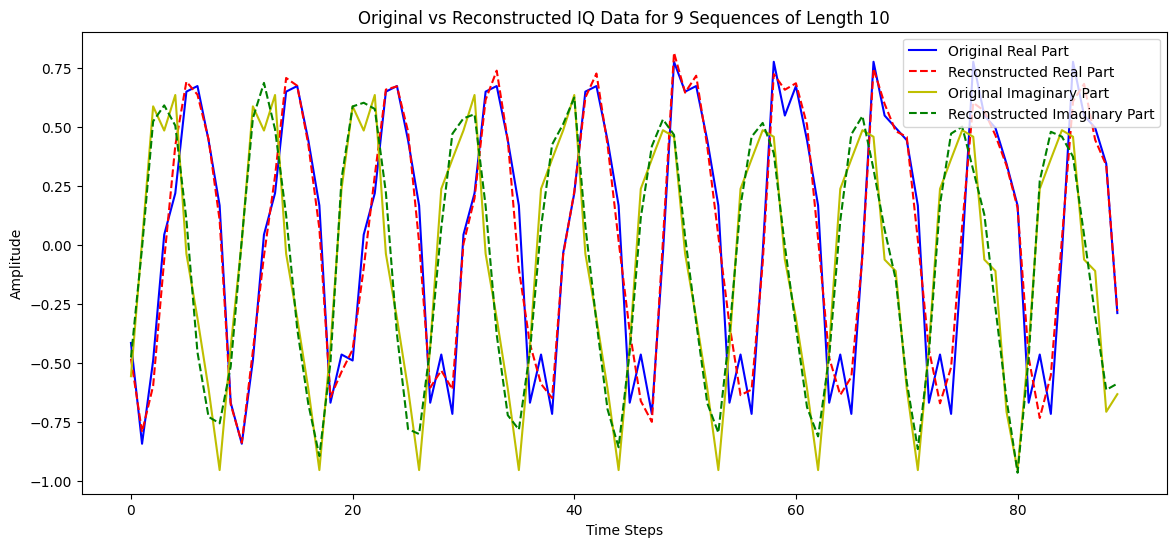

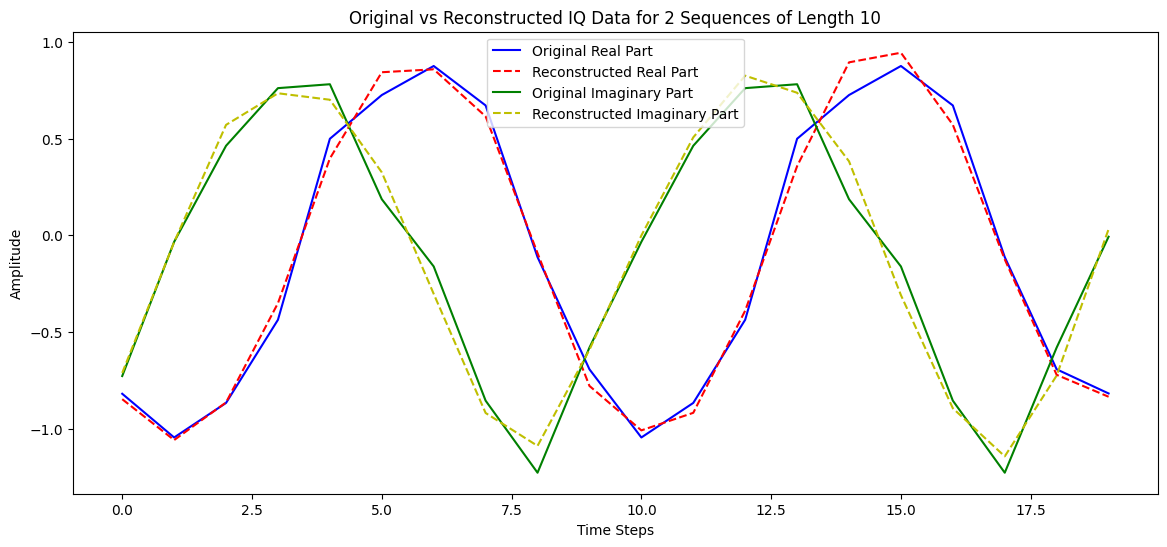

In [21]:
# # Define the number of sequences to plot together
n = 9  # Change this to desired number of sequences
sample_length = sequence_length * n

# Select a random starting sequence for plotting
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)

# Extract and concatenate the original and reconstructed samples
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

# Plot concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
# plt.plot(original_sample[:, 1], 'orange', label='Original Real STD')
# plt.plot(reconstructed_sample[:, 1], 'orange', label='Reconstructed Real STD', linestyle='--')

plt.plot(original_sample[:, 1], 'y-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'g--', label='Reconstructed Imaginary Part')
# plt.plot(original_sample[:, 5], 'pink', label='Original Imaginary STD')
# plt.plot(reconstructed_sample[:, 5], 'pink', label='Reconstructed Imaginary STD', linestyle='--')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('9-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

# Repeat for n = 9
n = 2  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

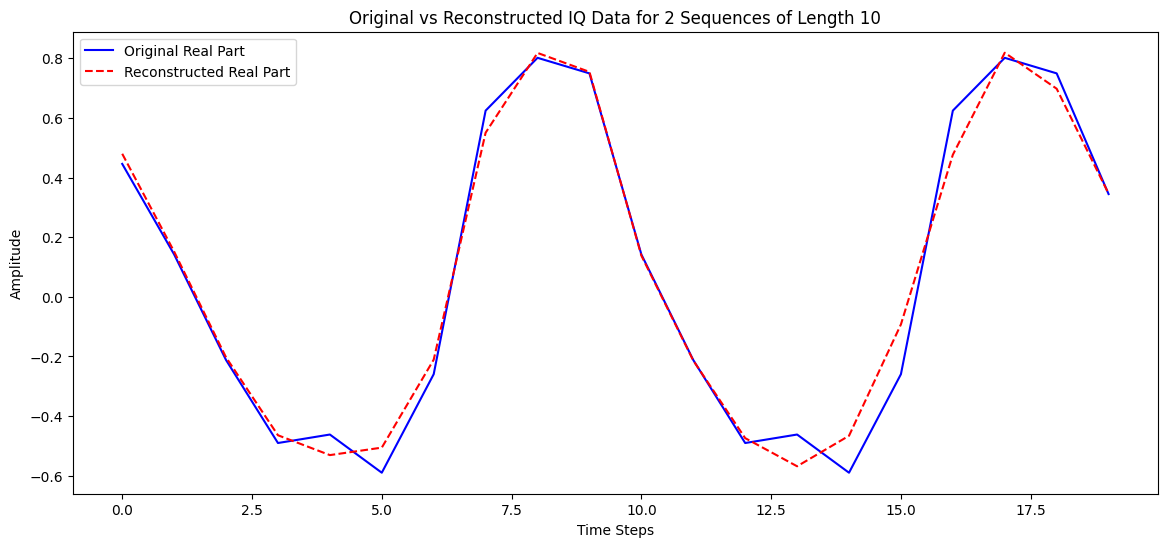

In [22]:
# Repeat for n = 9
n = 2  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')

plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

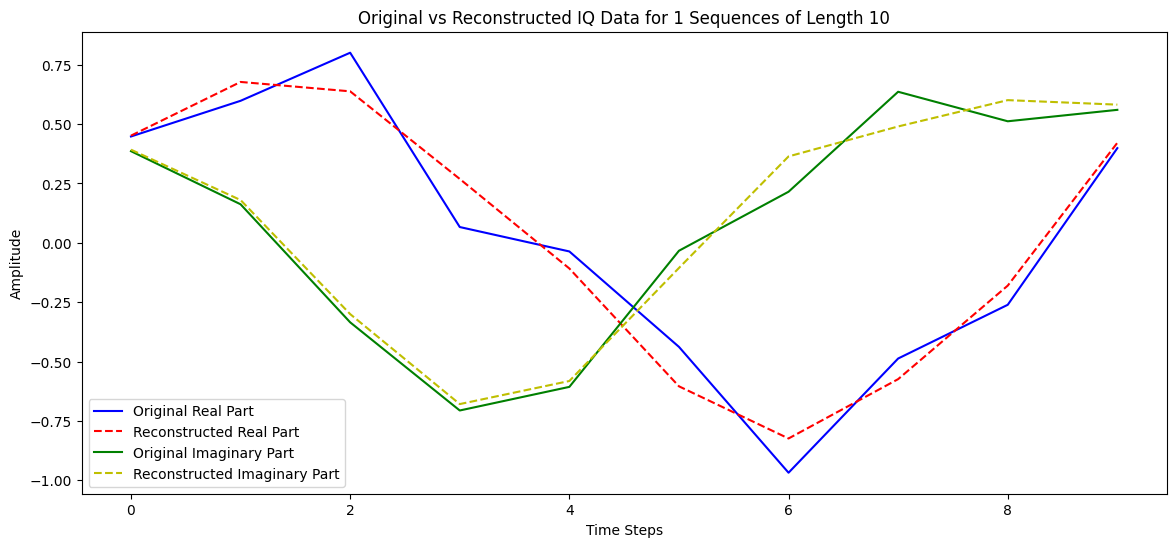

In [23]:
# Repeat for n = 9
n = 1  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

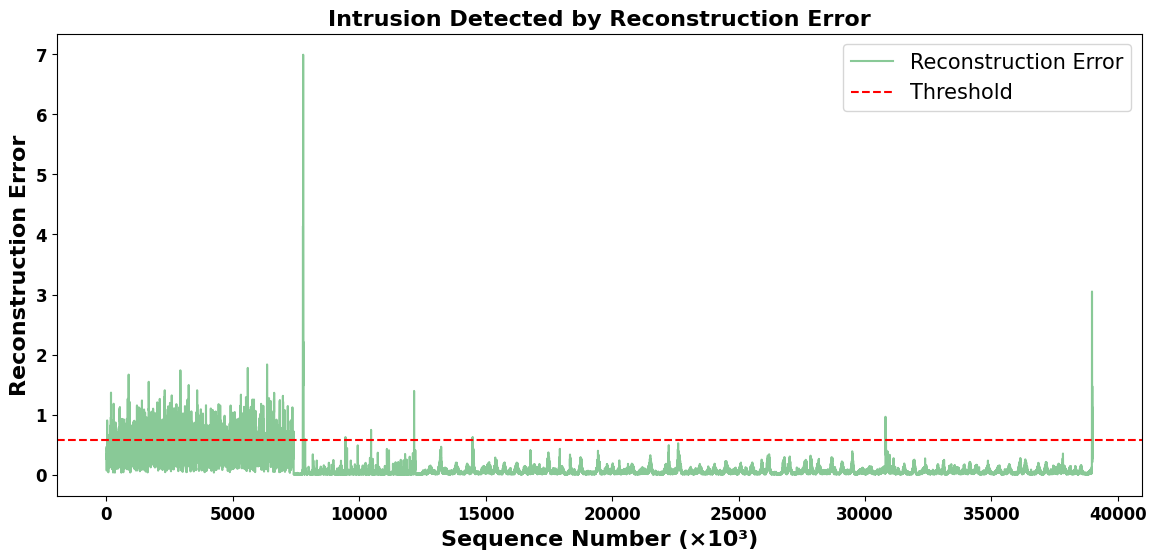

In [24]:
# reconstruction error
reconstruction_error_real = reconstruction_error[:, 0]
reconstruction_error_imag = reconstruction_error[:, 1]

# Plot for Real Part
plt.figure(figsize=(14, 6))
mellow_green = '#89C997' 
plt.plot(reconstruction_error_real, label='Reconstruction Error', color=mellow_green)
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Intrusion Detected by Reconstruction Error',fontsize=16, fontweight='bold')
plt.xlabel('Sequence Number (×10³)', fontsize=16, fontweight='bold')
#plt.xlabel('Sequence Number(*1000)', fontsize=16, fontweight='bold')
plt.ylabel('Reconstruction Error', fontsize=16, fontweight='bold')
for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    label.set_fontsize(12)
    label.set_fontweight('bold')
plt.legend(fontsize=15)
plt.show()

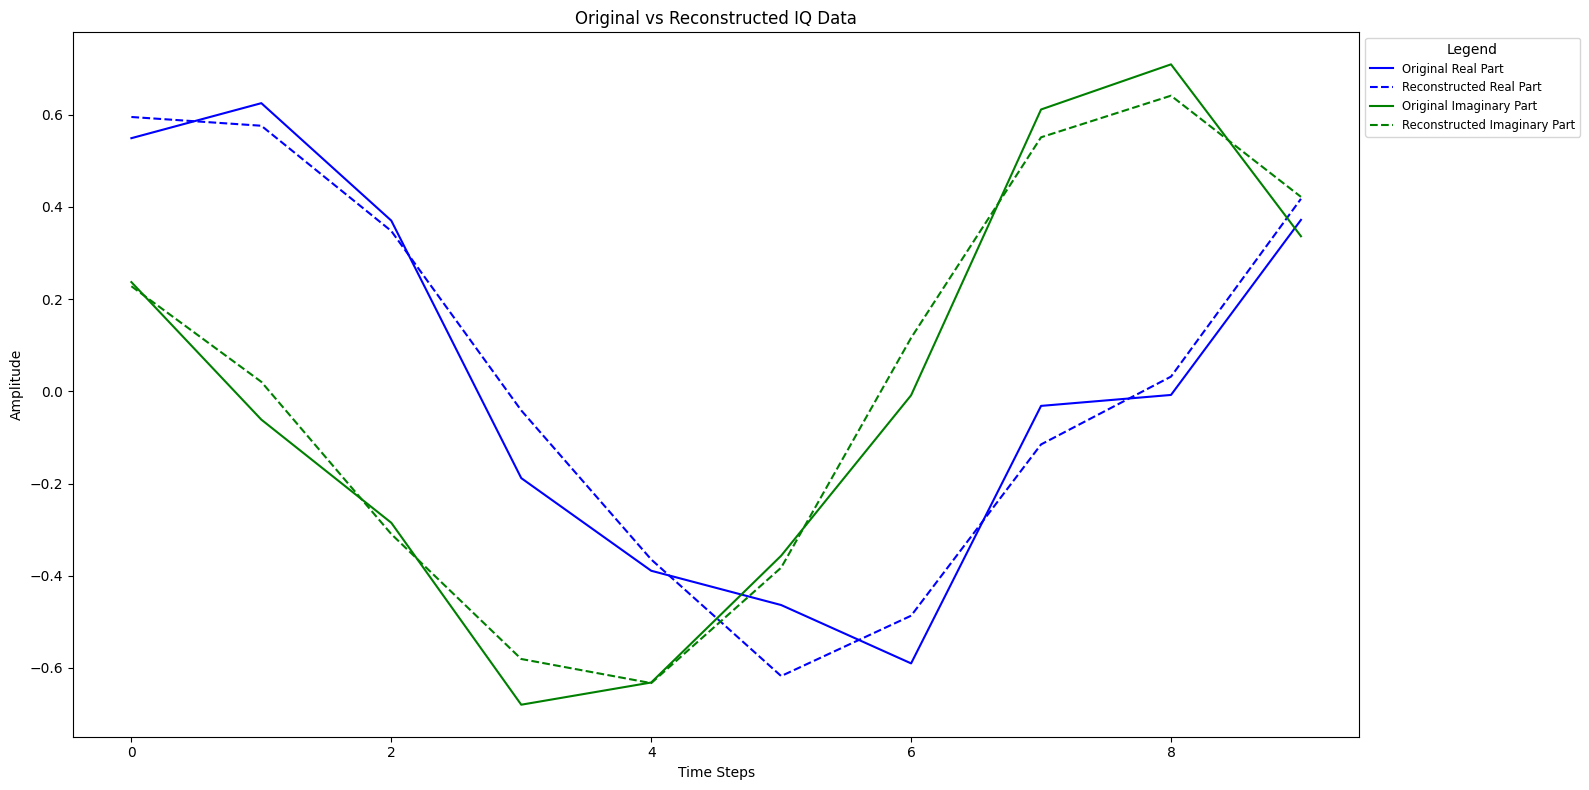

In [25]:
sample_index = np.random.choice(len(X_chunk_test))
original_sample = X_chunk_test[sample_index]
reconstructed_sample = X_chunk_pred[sample_index]

plt.figure(figsize=(16, 8))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'b--', label='Reconstructed Real Part')
# plt.plot(original_sample[:, 1], 'm-', label='Original Real STD')
# plt.plot(reconstructed_sample[:, 1], 'm--', label='Reconstructed Real STD')
# plt.plot(original_sample[:, 2], 'c-', label='Original Real Skew')
# plt.plot(reconstructed_sample[:, 2], 'c--', label='Reconstructed Real Skew')
# plt.plot(original_sample[:, 3], 'orange', label='Original Real Kurtosis')
# plt.plot(reconstructed_sample[:, 3], 'orange', label='Reconstructed Real Kurtosis', linestyle='--')

plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'g--', label='Reconstructed Imaginary Part')
# plt.plot(original_sample[:, 5], 'purple', label='Original Imaginary STD')
# plt.plot(reconstructed_sample[:, 5], 'purple', label='Reconstructed Imaginary STD', linestyle='--')
# plt.plot(original_sample[:, 6], 'brown', label='Original Imaginary Skew')
# plt.plot(reconstructed_sample[:, 6], 'brown', label='Reconstructed Imaginary Skew', linestyle='--')
# plt.plot(original_sample[:, 7], 'pink', label='Original Imaginary Kurtosis')
# plt.plot(reconstructed_sample[:, 7], 'pink', label='Reconstructed Imaginary Kurtosis', linestyle='--')
plt.title('Original vs Reconstructed IQ Data')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')

# Place the legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', title='Legend')

# Adjust layout to make room for the legend
plt.tight_layout()

plt.show()